# **Project 9: Heating and cooling power DFAB**

Course: Energy Data Engineering WS 2025-2026 Semester Project

Date: 20.01.2025

Team Members: Aya Abd Alahi, John Riecken

## **1. Introduction**

This project aims to predict the heating and cooling power demand of the DFAB unit at the NEST building using measured environmental and operational data, excluding valve position information. The workflow consists of an exploratory data analysis to understand the dataset and identify relevant features, followed by the training and evaluation of multiple linear regression models with varying complexity. Model performance is assessed using cross-validation, error metrics, and visual comparisons to select a final model that balances accuracy, robustness, and interpretability.

Task: Predict heating and cooling power using sensor data.
Method: 
* Explore the data, 
* Analyze correlations, and 
* Train at least linear 5 regression models of increasing complexity

Goal: Compare models, avoid overfitting, and select the best-performing and most stable regression model.


In [543]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_validate

In [544]:
# import data

df = pd.read_csv('../data/dfab_2019_2022_resampled.csv')
df.head()

,Unnamed: 0,time,heating_cooling_power,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,...,y2_574,y3_371,y3_472,y3_476,y3_571,y3_574,y4_371,y5_371,y6_371,y7_371
0,0,2019-07-01 00:00:00,-3.330995,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,0.400000,1.0,1.0,1.0,1.0
1,1,2019-07-01 00:15:00,-3.087947,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0
2,2,2019-07-01 00:30:00,-3.441945,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,0.600000,1.0,1.0,1.0,1.0
3,3,2019-07-01 00:45:00,-3.274495,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
4,4,2019-07-01 01:00:00,-3.298245,0.0,0.0,25.0,22.0,22.0,19.0,25.5,...,1.0,1.0,1.0,1.0,1.0,0.666667,1.0,1.0,1.0,1.0


In [545]:
# check metadata
# AI used for encoding

meta_df = pd.read_csv('../data/dfab_metadata.csv', encoding='iso-8859-1')

# Groups by Type and take the column names
meta_df.groupby('Type').first()

,NumericID,DescriptiveID,Description,Unit
Type,,,,
Electricity Kitchen,42190064,kitchen_active_power,Kitchen electric active power [kW],dfab
Electricity Total,42190139,total_active_power,Total electric active power [kW],dfab
Heating Cooling,421100172,heating_cooling_power,Heating and cooling power unit [kW],dfab
Index,Index,Index,Index,Index
Setpoint,421110050,setp_371,Temperature setpoint room 272 [°C],dfab
Solar Radiation,3200008,irrad,Global solar irradiation [W/m^2],roof
Temperature Ambient,3200000,temp_amb,Ambient temperature [°C],roof
Temperature Indoor,421110048,temp_371,Temperature room 371 [°C],dfab
Valve,421110008,y1_371,Valve 1 position room 371 [0/1],dfab


The dataset describes measurements taken at distinct regular points in time within a building (NEST). 

The measurements describe:
* the heating and cooling unit power, 
* active electric power (total and from the kitchen),
* solar radiation and ambient temperature on the roof,
* water consumption in showers for two rooms,
* the set temperature and associated actual temperature across 7 rooms (one of which has also shower -Room 571),
* various valve positions for each of the rooms 

In [546]:
# drop excluded variables
drop_list = ["y1_371", "y1_472", "y1_474", "y1_476", "y1_571", "y1_573", "y1_574", "y2_371", "y2_472", "y2_476", "y2_571", "y2_574", "y3_371", "y3_472", "y3_476", "y3_571", "y3_574", "y4_371", "y5_371", "y6_371", "y7_371", "Unnamed: 0"]
df.drop(columns=drop_list, inplace=True)
df.head()

,time,heating_cooling_power,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,...,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
0,2019-07-01 00:00:00,-3.330995,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,...,0.0,27.500000,26.5,28.0,29.0,31.0,30.500000,31.5,25.926667,0.575526
1,2019-07-01 00:15:00,-3.087947,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,...,0.0,27.500000,26.5,28.0,29.0,30.8,30.500000,31.5,25.586667,0.689346
2,2019-07-01 00:30:00,-3.441945,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,...,0.0,27.500000,26.5,28.0,29.0,30.5,30.500000,31.5,25.373333,0.675612
3,2019-07-01 00:45:00,-3.274495,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,...,0.0,27.500000,26.5,28.0,29.0,30.5,30.466667,31.5,25.333333,0.566832
4,2019-07-01 01:00:00,-3.298245,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,...,0.0,27.333333,26.5,28.0,29.0,30.5,30.000000,31.2,24.900000,0.481446


In [547]:
df.shape

(140256, 22)

In [548]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time                   140256 non-null  object 
 1   heating_cooling_power  138446 non-null  float64
 2   irrad                  137900 non-null  float64
 3   kitchen_active_power   138625 non-null  float64
 4   setp_371               132951 non-null  float64
 5   setp_472               133554 non-null  float64
 6   setp_474               132949 non-null  float64
 7   setp_476               132360 non-null  float64
 8   setp_571               132951 non-null  float64
 9   setp_573               132675 non-null  float64
 10  setp_574               132663 non-null  float64
 11  shower_471             138776 non-null  float64
 12  shower_571             137960 non-null  float64
 13  temp_371               137795 non-null  float64
 14  temp_472               137710 non-nu

### **Initial Look at the Dataset**

- all columns (except time) are floats, making preprocessing easier
- all columns have contain nulls as the non-null counts are all less than those in 'time'
  - in the source material values outside of a defined range for each measurement were set to *Missing Value* 
  - there were also network outages and temporarily defected sensors which caused NaNs
- Time is an object and not recognised by pandas as a time
- extra column (unnamed) for the index is not needed

# **2. Part 1: Exploratory Data Analysis (EDA)**

### **2.1 Statistical Summary**

Show basic stats (mean, median, std dev) and handle any missing values.


In [549]:
focus_cols = ['heating_cooling_power', 'irrad', 'total_active_power', 'kitchen_active_power',
    'temp_amb', 'shower_471', 'setp_371', 'temp_371']

df[focus_cols].describe()

,heating_cooling_power,irrad,total_active_power,kitchen_active_power,temp_amb,shower_471,setp_371,temp_371
count,138446.000000,137900.000000,138936.000000,138625.000000,139273.000000,138776.000000,132951.000000,137795.000000
mean,0.157416,184.621133,-0.105771,0.041175,12.073460,0.005121,22.138905,23.571796
std,1.833801,303.647495,1.437322,0.211394,8.459903,0.163586,2.403091,2.109775
min,-8.420386,0.000000,-6.151530,0.000000,-9.940000,0.000000,10.000000,18.500000
25%,-1.113597,0.000000,-0.376740,0.000000,5.306667,0.000000,22.000000,22.000000
50%,0.000000,11.266667,0.443226,0.000000,11.566667,0.000000,22.000000,23.000000
75%,1.496797,249.133333,0.644574,0.000000,18.033333,0.000000,23.500000,25.000000
max,6.418994,1250.000000,7.180404,5.157067,40.120000,28.270000,28.000000,46.000000


In [550]:
# chceck for missing values
df.isna().sum()

time                        0
heating_cooling_power    1810
irrad                    2356
kitchen_active_power     1631
setp_371                 7305
setp_472                 6702
setp_474                 7307
setp_476                 7896
setp_571                 7305
setp_573                 7581
setp_574                 7593
shower_471               1480
shower_571               2296
temp_371                 2461
temp_472                 2546
temp_474                 2806
temp_476                 3370
temp_571                 3018
temp_573                 2835
temp_574                 2895
temp_amb                  983
total_active_power       1320
dtype: int64

In [551]:
# columns ok to have zeros: heating_coolling, irrad, active elec, shower
# check columns: amb_temp, indoor temp, set temp

# df[df['temp_amb'] == 0]b
df[df['temp_amb'].isna()]

,time,heating_cooling_power,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,...,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
5286,2019-08-25 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5287,2019-08-25 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5288,2019-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5289,2019-08-25 02:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5290,2019-08-25 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105211,2022-06-30 22:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105212,2022-06-30 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105213,2022-06-30 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105214,2022-06-30 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [552]:
# with ~140k rows try dropping all NaNs
# before
print ("Before droping Nan")
print(df.shape)


df_clean = df.dropna()
print ("\nAfter droping Nan")
print(df_clean.shape)

Before droping Nan
(140256, 22)

After droping Nan
(130303, 22)


In [553]:
df_clean.isna().sum()

time                     0
heating_cooling_power    0
irrad                    0
kitchen_active_power     0
setp_371                 0
setp_472                 0
setp_474                 0
setp_476                 0
setp_571                 0
setp_573                 0
setp_574                 0
shower_471               0
shower_571               0
temp_371                 0
temp_472                 0
temp_474                 0
temp_476                 0
temp_571                 0
temp_573                 0
temp_574                 0
temp_amb                 0
total_active_power       0
dtype: int64

In [554]:
# check duplicates
# df['time'].duplicated().sum()
df_clean.duplicated().sum()

np.int64(0)

In [555]:
# convert Time to timeseries dtype
df_clean['time'] = pd.to_datetime(df['time'])
df_clean = df_clean.set_index('time')
df_clean = df_clean.sort_values('time')
df_clean.info()

df_original= df_clean.copy()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130303 entries, 2019-07-01 00:00:00 to 2023-06-29 23:45:00
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   heating_cooling_power  130303 non-null  float64
 1   irrad                  130303 non-null  float64
 2   kitchen_active_power   130303 non-null  float64
 3   setp_371               130303 non-null  float64
 4   setp_472               130303 non-null  float64
 5   setp_474               130303 non-null  float64
 6   setp_476               130303 non-null  float64
 7   setp_571               130303 non-null  float64
 8   setp_573               130303 non-null  float64
 9   setp_574               130303 non-null  float64
 10  shower_471             130303 non-null  float64
 11  shower_571             130303 non-null  float64
 12  temp_371               130303 non-null  float64
 13  temp_472               130303 non-null  float64
 14  te

/tmp/ipykernel_26627/1781228412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['time'] = pd.to_datetime(df['time'])


In [556]:
df_original.head()

,heating_cooling_power,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,setp_574,...,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
time,,,,,,,,,,,,,,,,,,,,,
2019-07-01 00:00:00,-3.330995,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.500000,26.5,28.0,29.0,31.0,30.500000,31.5,25.926667,0.575526
2019-07-01 00:15:00,-3.087947,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.500000,26.5,28.0,29.0,30.8,30.500000,31.5,25.586667,0.689346
2019-07-01 00:30:00,-3.441945,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.500000,26.5,28.0,29.0,30.5,30.500000,31.5,25.373333,0.675612
2019-07-01 00:45:00,-3.274495,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.500000,26.5,28.0,29.0,30.5,30.466667,31.5,25.333333,0.566832
2019-07-01 01:00:00,-3.298245,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,...,0.0,27.333333,26.5,28.0,29.0,30.5,30.000000,31.2,24.900000,0.481446


### **2.2 Visual Exploration - Target**

Look into the target to find insights. 

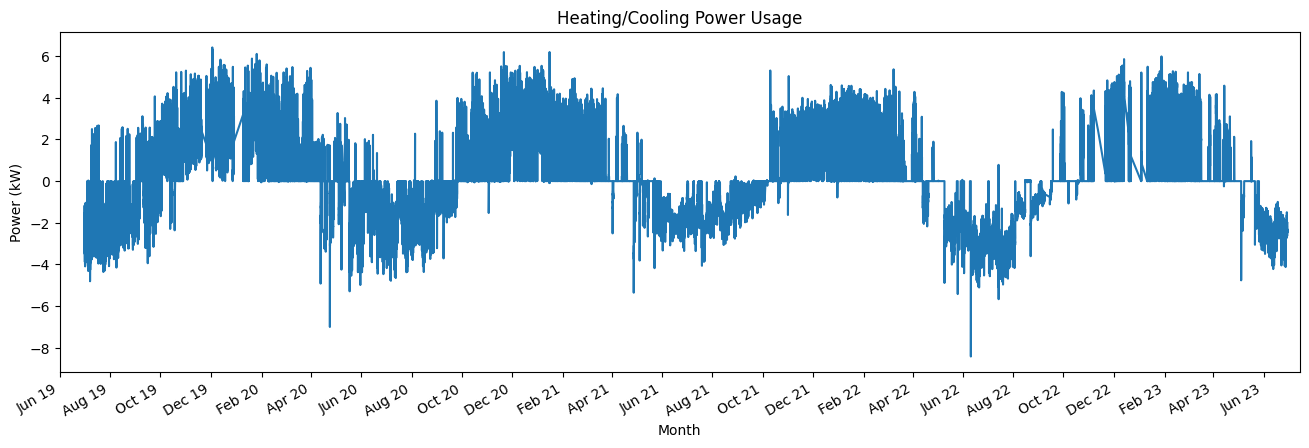

In [557]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(df_clean.index, df_clean['heating_cooling_power'])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.title('Heating/Cooling Power Usage')
plt.xlabel('Month')
plt.ylabel('Power (kW)')

fig.autofmt_xdate()
plt.xlim(left=pd.Timestamp('2019-06-01'), right=pd.Timestamp('2023-07-15'))
plt.show()

The Power Usage graph shows that negative power is recorded in summer months. Therefore power used for cooling will be taken as negative power and power used for heating will be positive power, and 0-values will be taken as turned off.

The system is off 28.72% of the time.


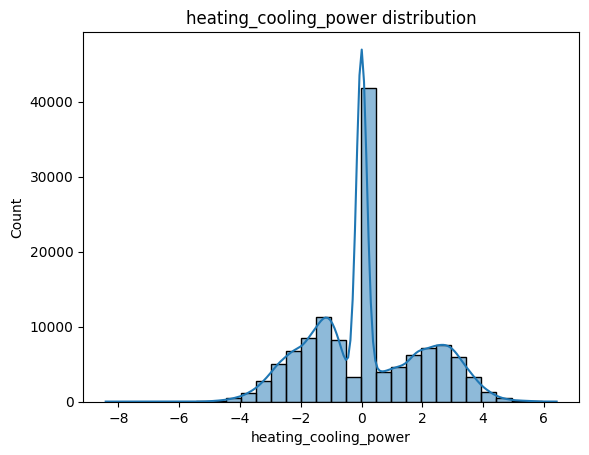

In [558]:
sns.histplot(data=df_clean['heating_cooling_power'], kde=True, bins=30)
plt.title('heating_cooling_power distribution')

# heavily modal around 0, meaning it's predominantly off
# The percentage of time the system is off
off_percentage = (df_clean['heating_cooling_power'] == 0).mean() * 100

print(f"The system is off {off_percentage:.2f}% of the time.")

Text(0.5, 1.0, 'heating_cooling_power when unit is ON')

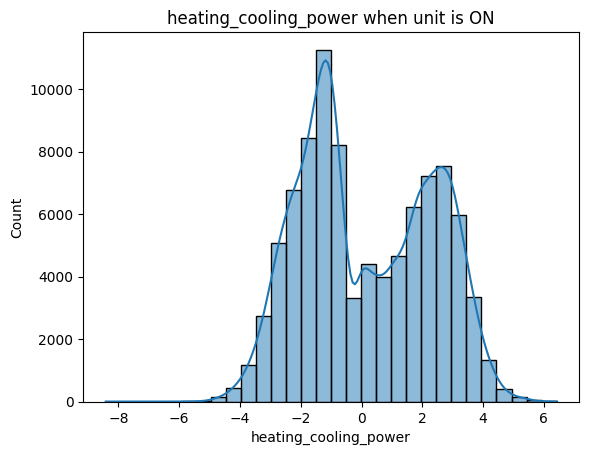

In [559]:
# when the system is on
# View the distribution ONLY when the system is actually running
sns.histplot(df_clean[df_clean['heating_cooling_power'] != 0]['heating_cooling_power'], kde=True, bins=30)
plt.title('heating_cooling_power when unit is ON')

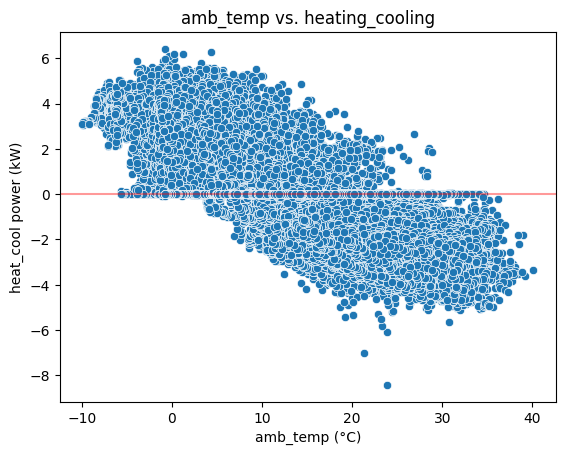

In [560]:
# check if there is correlation between ambient outside temp and switching unit ON
sns.scatterplot(data=df_clean, x='temp_amb', y='heating_cooling_power')
plt.axhline(0, color='r', alpha=0.4)
plt.title('amb_temp vs. heating_cooling')
plt.xlabel('amb_temp (°C)')
plt.ylabel('heat_cool power (kW)')
plt.show()

Unfortunately no discernable threshold for which temperature the unit is ON or OFF

In [561]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130303 entries, 2019-07-01 00:00:00 to 2023-06-29 23:45:00
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   heating_cooling_power  130303 non-null  float64
 1   irrad                  130303 non-null  float64
 2   kitchen_active_power   130303 non-null  float64
 3   setp_371               130303 non-null  float64
 4   setp_472               130303 non-null  float64
 5   setp_474               130303 non-null  float64
 6   setp_476               130303 non-null  float64
 7   setp_571               130303 non-null  float64
 8   setp_573               130303 non-null  float64
 9   setp_574               130303 non-null  float64
 10  shower_471             130303 non-null  float64
 11  shower_571             130303 non-null  float64
 12  temp_371               130303 non-null  float64
 13  temp_472               130303 non-null  float64
 14  te

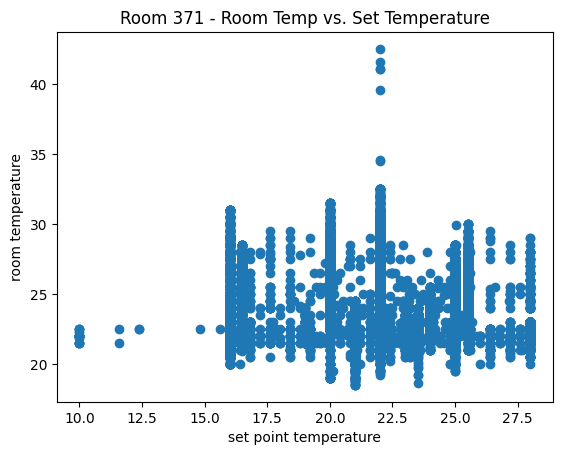

In [562]:
plt.scatter(x=df_clean['setp_371'], y=df_clean['temp_371'])
plt.title(f'Room 371 - Room Temp vs. Set Temperature')
plt.xlabel('set point temperature')
plt.ylabel('room temperature')
plt.show()

Nothing discernable

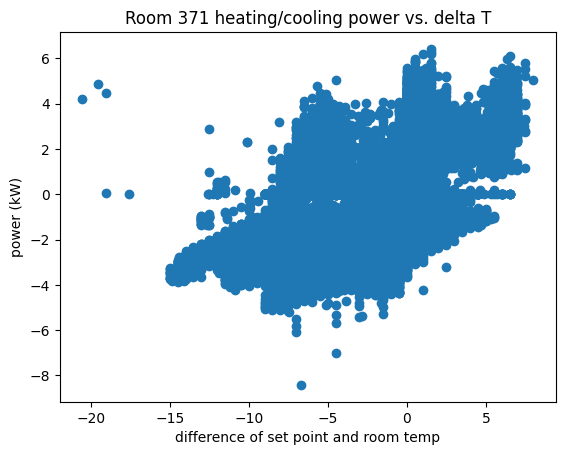

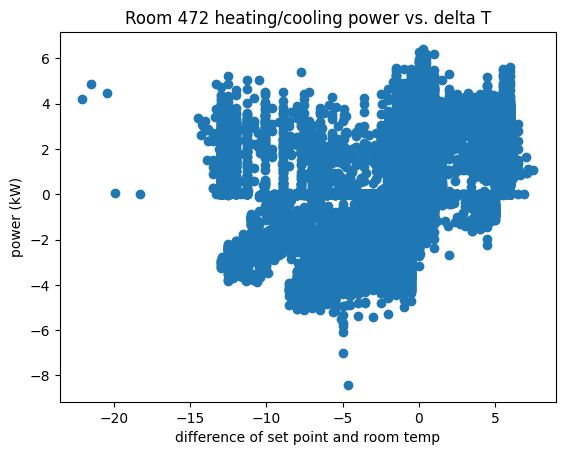

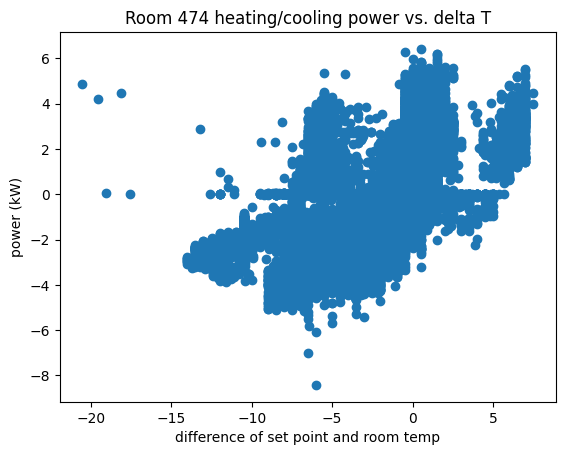

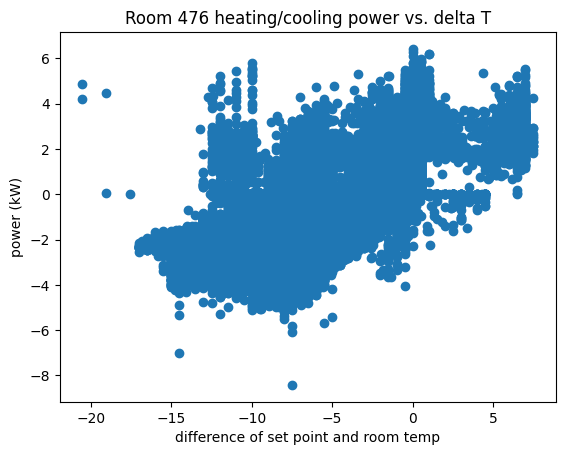

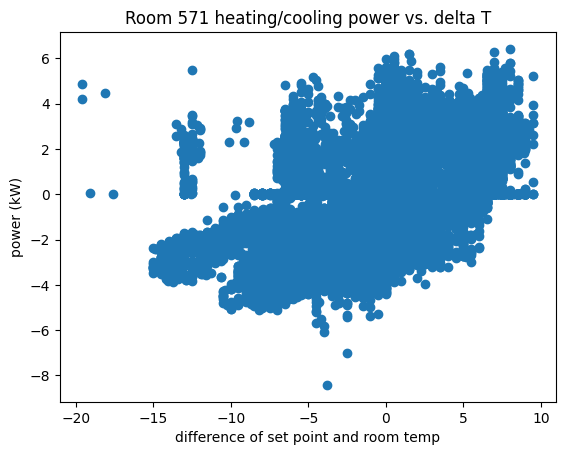

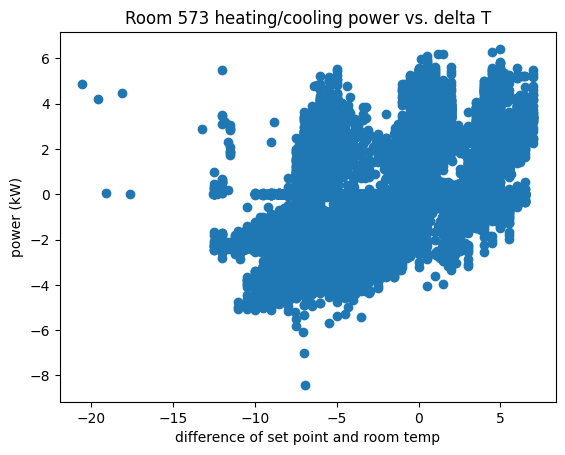

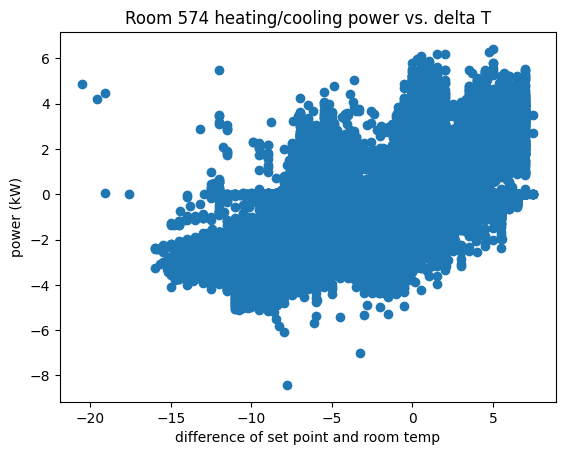

In [563]:
room_nums = ['371', '472', '474', '476', '571', '573', '574']

for room in room_nums:
    df_clean[f'delta_T_{room}'] = df_clean[f'setp_{room}'] - df_clean[f'temp_{room}']
    plt.scatter(x=df_clean[f'delta_T_{room}'], y=df_clean['heating_cooling_power'])
    plt.title(f'Room {room} heating/cooling power vs. delta T')
    plt.xlabel('difference of set point and room temp')
    plt.ylabel('power (kW)')
    plt.show()

All rooms following a similar pattern - the bigger difference is usually associated with cooling i.e. likely in summer on hot days 

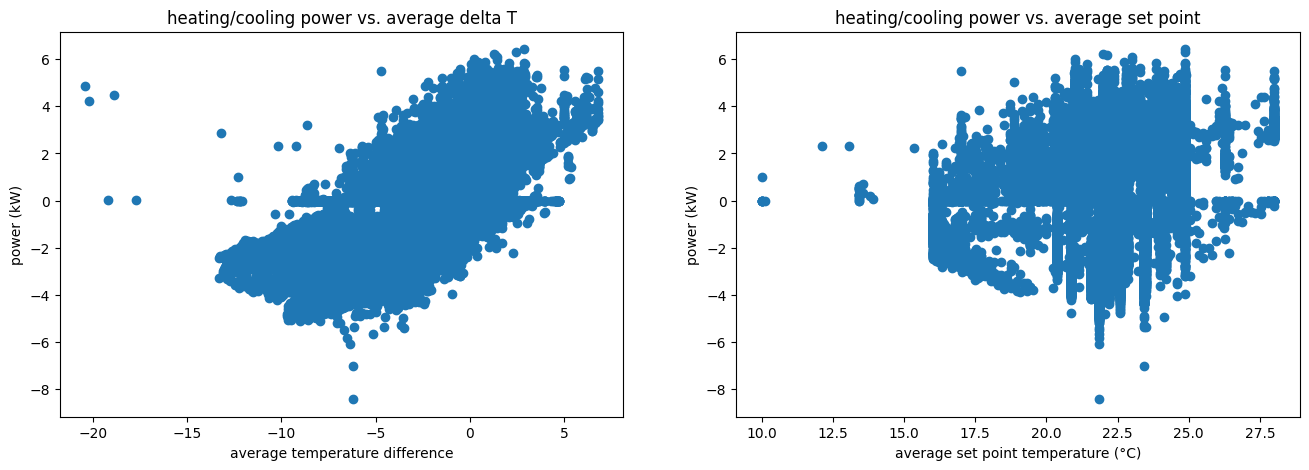

In [564]:
delta_cols = [f'delta_T_{room}' for room in room_nums]
set_pt_cols = [f'setp_{room}' for room in room_nums]
df_clean['av_delta_T'] = df_clean[delta_cols].mean(axis=1)  # creating an average delta T column
df_clean['av_setp'] = df_clean[set_pt_cols].mean(axis=1)    # creating an average setpoint column

fig, ax = plt.subplots(1,2, figsize=(16,5))

ax[0].scatter(x=df_clean['av_delta_T'], y=df_clean['heating_cooling_power'])
ax[0].set_title('heating/cooling power vs. average delta T')
ax[0].set_xlabel('average temperature difference')
ax[0].set_ylabel('power (kW)')

ax[1].scatter(x=df_clean['av_setp'], y=df_clean['heating_cooling_power'])
ax[1].set_title('heating/cooling power vs. average set point')
ax[1].set_xlabel('average set point temperature (°C)')
ax[1].set_ylabel('power (kW)')

plt.show()

The change in temperature shows more correlation with the power than the set point. The average difference between the room set point temperature and the target have more of a trend than individual differences. The wide spread could be due to the size of each room so a weighted size averaged should be looked at. 

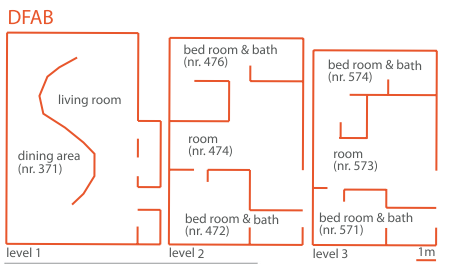

From the above plan of DFAB:

Total of these spaces: 475 m^2
The remaining -235 m^2 accounts for the core/stairs/walls


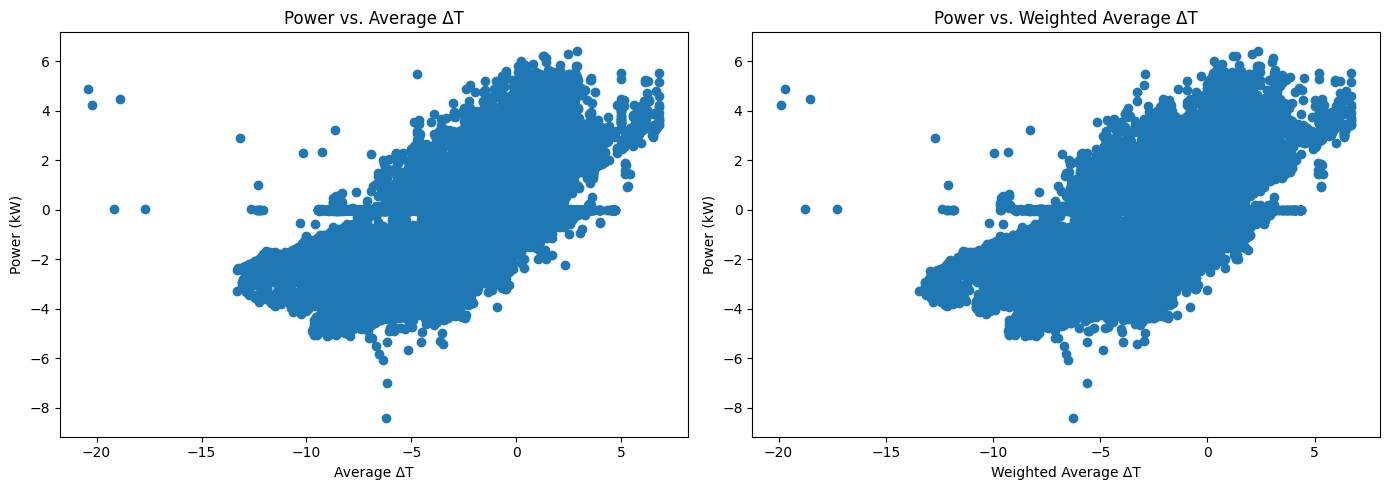

In [565]:
# approximate room area (m^2)
# total area is 240m^2 from the report

room_areas = {
    "total_area": 240,
    "371": 102,  # Main Living/Dining/Kitchen level
    "476": 24,   # Bed room & bath
    "474": 20,   # Room
    "472": 22,   # Bed room & bath
    "574": 22,   # Bed room & bath
    "573": 26,   # Room
    "571": 19    # Bed room & bath
}

print(f'Total of these spaces: {sum(room_areas.values())} m^2\nThe remaining {240-sum(room_areas.values())} m^2 accounts for the core/stairs/walls')

weights = [room_areas[room] for room in room_nums]
df_clean['weighted_av_delta_T'] = df_clean[delta_cols].dot(weights)/room_areas['total_area']

fig, ax = plt.subplots(1,2, figsize=(14,5))
# Unweighted
ax[0].scatter(
    df_clean['av_delta_T'],
    df_clean['heating_cooling_power']
)
ax[0].set_title('Power vs. Average ΔT')
ax[0].set_xlabel('Average ΔT')
ax[0].set_ylabel('Power (kW)')

# Weighted
ax[1].scatter(
    df_clean['weighted_av_delta_T'],
    df_clean['heating_cooling_power']
)
ax[1].set_title('Power vs. Weighted Average ΔT')
ax[1].set_xlabel('Weighted Average ΔT')
ax[1].set_ylabel('Power (kW)')

plt.tight_layout()
plt.show()

todo:describe above

### **2.3 Visual Exploration - Features**

In [566]:
# split data into feature and targets
target = "heating_cooling_power"
y = df_original[target]
X = df_original.drop(columns=[target])  # Features


In [567]:
# target (y)
df_original[[target]]

,heating_cooling_power
time,
2019-07-01 00:00:00,-3.330995
2019-07-01 00:15:00,-3.087947
2019-07-01 00:30:00,-3.441945
2019-07-01 00:45:00,-3.274495
2019-07-01 01:00:00,-3.298245
...,...
2023-06-29 22:45:00,-2.227025
2023-06-29 23:00:00,-2.174749
2023-06-29 23:15:00,-2.051341


In [568]:
X

,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,setp_574,shower_471,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
time,,,,,,,,,,,,,,,,,,,,
2019-07-01 00:00:00,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,0.0,0.0,27.500000,26.500000,28.000000,29.0,31.0,30.500000,31.5,25.926667,0.575526
2019-07-01 00:15:00,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,0.0,0.0,27.500000,26.500000,28.000000,29.0,30.8,30.500000,31.5,25.586667,0.689346
2019-07-01 00:30:00,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,0.0,0.0,27.500000,26.500000,28.000000,29.0,30.5,30.500000,31.5,25.373333,0.675612
2019-07-01 00:45:00,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,0.0,0.0,27.500000,26.500000,28.000000,29.0,30.5,30.466667,31.5,25.333333,0.566832
2019-07-01 01:00:00,0.0,0.0,25.0,22.0,22.0,19.0,25.5,22.0,19.0,0.0,0.0,27.333333,26.500000,28.000000,29.0,30.5,30.000000,31.2,24.900000,0.481446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29 22:45:00,0.0,0.0,20.0,22.0,22.0,16.0,22.0,22.0,22.0,0.0,0.0,26.000000,25.566667,26.266667,26.5,26.0,26.500000,27.5,19.726667,1.048530
2023-06-29 23:00:00,0.0,0.0,20.0,22.0,22.0,16.0,22.0,22.0,22.0,0.0,0.0,25.833333,25.500000,26.000000,26.5,26.0,26.500000,27.5,19.833333,0.961422
2023-06-29 23:15:00,0.0,0.0,20.0,22.0,22.0,16.0,22.0,22.0,22.0,0.0,0.0,25.500000,25.500000,26.000000,26.5,26.0,26.500000,27.5,19.880000,1.007874


In [569]:
# first statistical impression of the data
X.describe()

,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,setp_574,shower_471,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
count,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000,130303.000000
mean,190.685105,0.039157,22.144627,21.866235,21.904696,20.450806,22.691721,22.109920,22.271048,0.004520,0.004425,23.637404,23.311587,23.424821,24.037257,23.393025,23.793341,24.225002,12.184922,-0.091224
std,308.170251,0.205856,2.406038,1.903229,1.332511,2.577246,2.698232,2.077944,2.576018,0.141016,0.107685,2.059017,1.687918,2.180016,2.619702,2.146765,2.368494,2.730370,8.403944,1.384815
min,0.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,18.500000,17.500000,19.000000,19.000000,18.500000,19.000000,19.500000,-9.940000,-6.151530
25%,0.000000,0.000000,22.000000,22.000000,22.000000,19.000000,22.000000,22.000000,22.000000,0.000000,0.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,5.436667,-0.380205
50%,13.133333,0.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,0.000000,0.000000,23.000000,23.000000,22.500000,23.000000,22.500000,23.000000,23.500000,11.840000,0.440580
75%,265.066667,0.000000,23.500000,23.000000,22.000000,22.000000,24.500000,22.000000,23.000000,0.000000,0.000000,25.000000,24.000000,25.000000,26.000000,24.500000,25.500000,26.000000,18.093333,0.636300
max,1250.000000,5.157067,28.000000,28.000000,28.000000,28.000000,30.000000,28.500000,29.000000,22.670000,7.921111,42.533333,45.066667,42.533333,42.533333,41.566667,42.533333,43.500000,40.120000,7.180404


### **2.4 Correlation Analysis**

Heatmaps showing the relationship between features and the target variable.

### Heatmap: Relationships between features and target

#### Feature-Target Correlations
1. Strong negativ correlation:
    - temp_amb (ambient temperature) → -0.82 and room temperatures
    - Interpretation: When temperature rises, heating power decreases → logical for heating systems
2. Positive correlation
    - total_active_power → +0.30 
        * Probably total electricity consumption → increases with heating/cooling power
    - setp_476 → +0.41
        * Possibly temperature setpoint → higher setpoints → more heating power
    - irradiation (irrad) has a negative correlation with heating_cooling_power (-0.31)
        * Sunlight reduces heating demand → logical

#### Feature-Feature Correlations
1. The temperature features temp_474 to temp_574 are strongly correlated with each other (>0.9)
2. setp_371, setp_472, setp_474, setp_571, setp_573, setp_574 are partially strongly correlated (0.5–0.7)
    - Could represent uniform setpoints across different rooms.
3. Features with little effect on heating power
    - kitchen_active_power, shower_471, shower_571


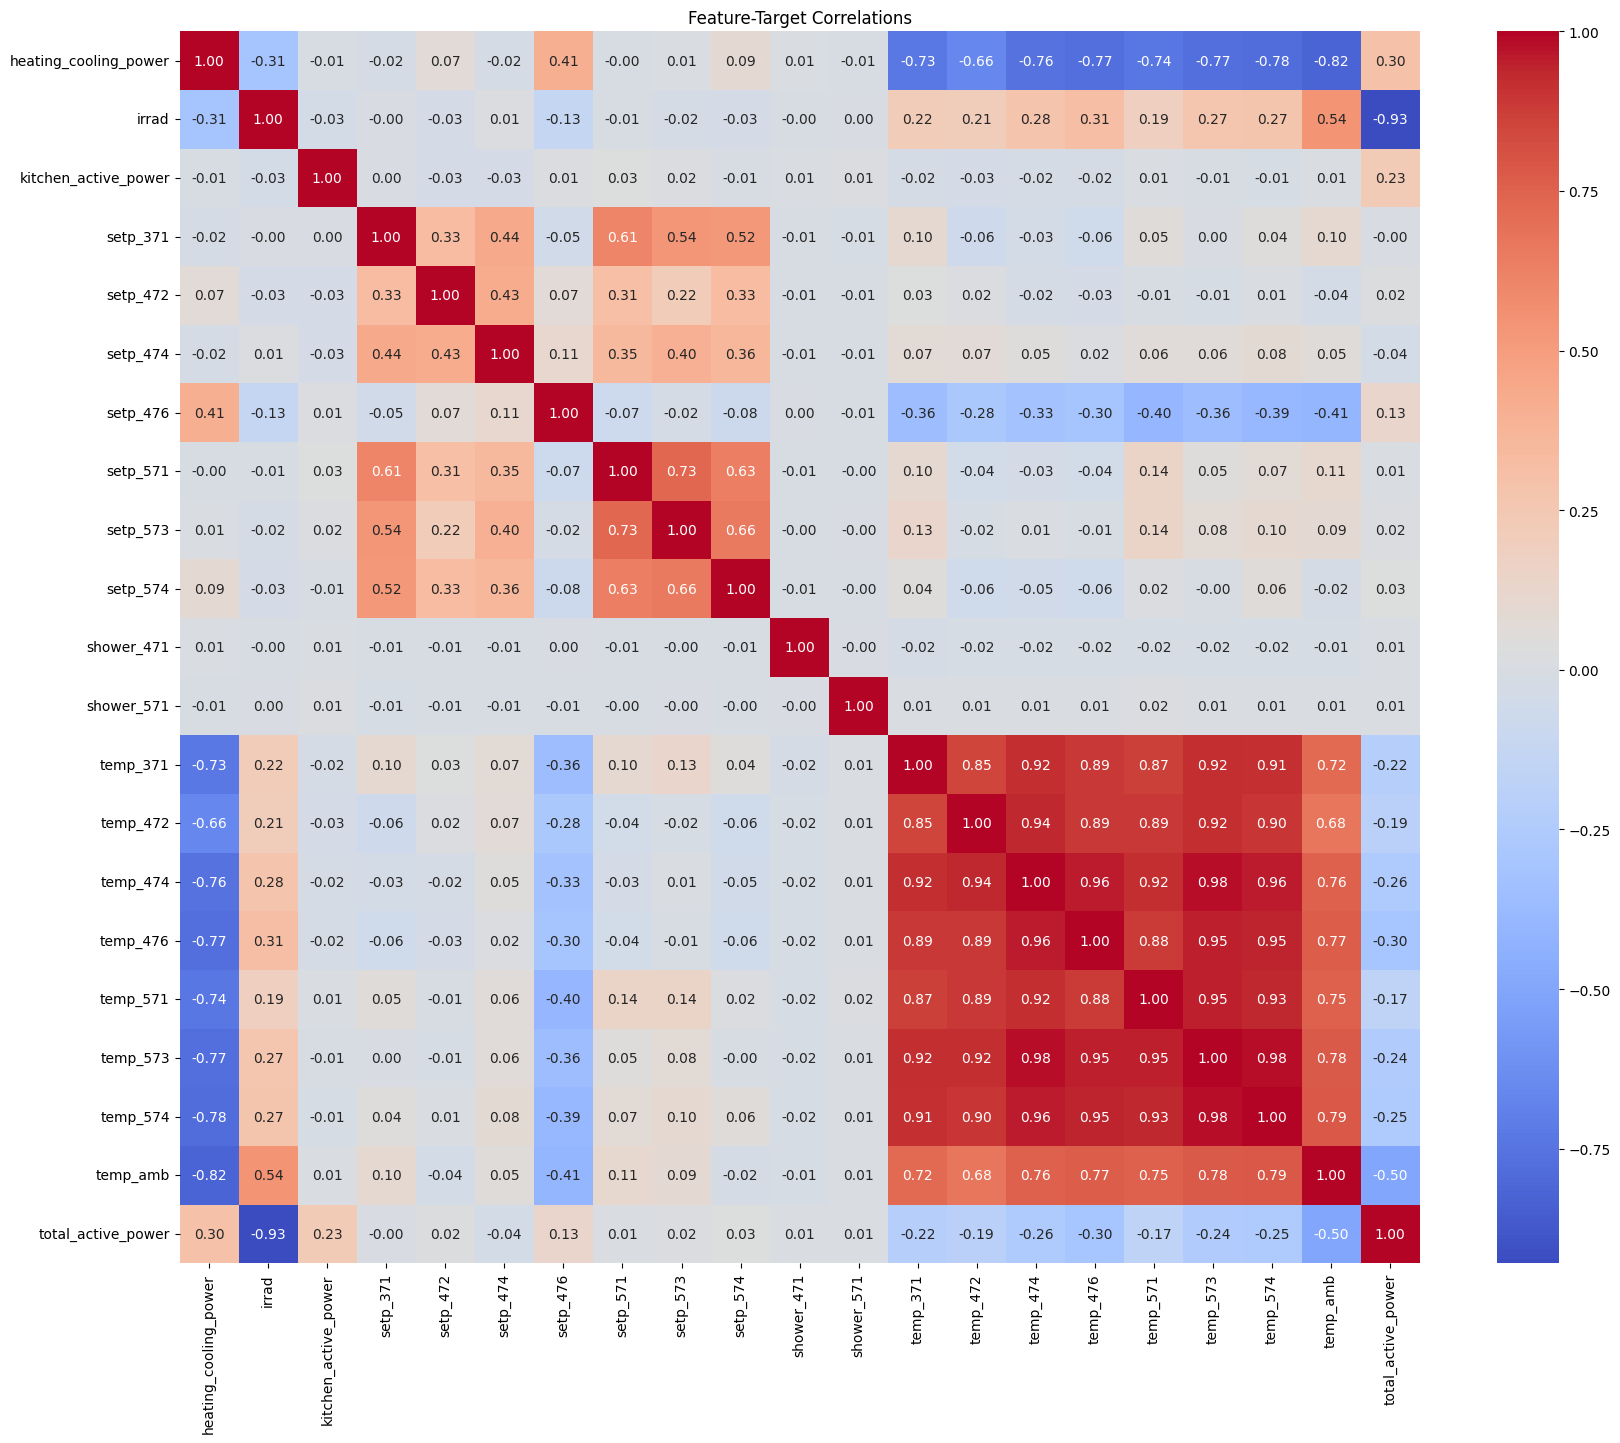

In [570]:
# 1. Korrelation aller Features + Target
corr_matrix = df_original.corr()

# 2. Heatmap der Feature-Target-Korrelationen (nur 1 Spalte)
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature-Target Correlations")
plt.show()


# **3. Part 2: Linear Regression Modeling**

### **3.1 Data Preprocessing**

Train-test splits, scaling, or encoding categorical variables.

#### Data Preprocessing Pipeline

* **Train-Test Split**: We split the data (80/20) to simulate unseen data and evaluate generalization.

* **Scaling**: We apply StandardScaler to normalize features (mean=0, std=1).

In [571]:
# Perform the Split (80% Train, 20% Test)
feature_train, feature_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Scaling)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(feature_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_train.columns, index=feature_train.index)

X_test_scaled = scaler.transform(feature_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_test.columns,  index=feature_test.index)


In [572]:
# Before standardScaler
feature_train.head()

,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,setp_574,shower_471,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
time,,,,,,,,,,,,,,,,,,,,
2023-02-25 17:30:00,15.133333,0.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,0.0,0.0,21.0,21.0,21.0,21.0,21.0,21.000000,20.5,4.000000,0.943194
2021-03-21 12:45:00,159.800000,0.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,0.0,0.0,22.0,22.0,21.5,22.5,22.0,22.000000,22.0,4.506667,-0.301686
2023-01-13 03:30:00,0.000000,0.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,0.0,0.0,21.0,21.0,21.0,21.0,21.0,21.000000,21.0,8.740000,0.558096
2019-12-17 12:45:00,175.000000,0.0,23.0,22.0,22.0,21.0,21.5,27.0,23.0,0.0,0.0,22.0,22.0,20.5,21.5,22.0,21.133333,22.0,9.560000,-0.397950
2022-08-23 00:45:00,0.000000,0.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,0.0,0.0,28.0,27.5,28.0,29.5,28.0,28.500000,29.5,17.580000,0.650118


In [573]:
# After StandardScaler
X_train_scaled.head()

,irrad,kitchen_active_power,setp_371,setp_472,setp_474,setp_476,setp_571,setp_573,setp_574,shower_471,shower_571,temp_371,temp_472,temp_474,temp_476,temp_571,temp_573,temp_574,temp_amb,total_active_power
time,,,,,,,,,,,,,,,,,,,,
2023-02-25 17:30:00,-0.569997,-0.189532,-0.475328,-0.456298,-0.678983,0.210606,-0.625095,-0.531825,-0.492718,-0.031435,-0.040984,-1.279373,-1.369199,-1.111008,-1.158508,-1.112736,-1.177772,-1.362681,-0.971143,0.748026
2021-03-21 12:45:00,-0.100057,-0.189532,-0.059422,0.069789,0.071727,0.599214,-0.254274,-0.051239,-0.104587,-0.031435,-0.040984,-0.793219,-0.775695,-0.881324,-0.585128,-0.646525,-0.755055,-0.812644,-0.910827,-0.152377
2023-01-13 03:30:00,-0.619157,-0.189532,-0.475328,-0.456298,-0.678983,0.210606,-0.625095,-0.531825,-0.492718,-0.031435,-0.040984,-1.279373,-1.369199,-1.111008,-1.158508,-1.112736,-1.177772,-1.179335,-0.406867,0.469490
2019-12-17 12:45:00,-0.050681,-0.189532,0.356483,0.069789,0.071727,0.210606,-0.439684,2.351696,0.283544,-0.031435,-0.040984,-0.793219,-0.775695,-1.340691,-0.967381,-0.646525,-1.121410,-0.812644,-0.309249,-0.222004
2022-08-23 00:45:00,-0.619157,-0.189532,-0.059422,0.069789,0.071727,0.599214,-0.254274,-0.051239,-0.104587,-0.031435,-0.040984,2.123711,2.488578,2.104564,2.090645,2.150743,1.992605,1.937540,0.645498,0.536048


### **3.2 Initial Model Iterations**


#### Modeling Strategy: 5 Initial Candidate Models

We compare five linear approaches to find the best balance between complexity and performance:

* **Simple Linear Regression**: Uses one feature to predict the target. Shows basic correlation.
* **Multiple Linear Regression**: Uses all features linearly.
* **Polynomial Regression (Degree 2)**: Captures non-linear relationships by considering feature interactions (curves).
* **Lasso Regression (L1)**: Performs automatic feature selection by shrinking less important coefficients to zero.       
                                - Effect on data: Some features are basically ignored → automatic feature selection.
* **Ridge Regression (L2)**: Reduces overfitting by penalizing large coefficients, keeping all features but reducing their    
impact.   
-Effect on data: No feature is removed, but the model is less extreme → avoids overfitting.

In [574]:
# --- PART 2: Model Training ---

# Dictionary to store our trained models
models = {}

# 1. Simple Linear Regression
# Baseline: Uses only the first feature (e.g., Temperature or Lag_1)
X_train_simple =  X_train_scaled.loc[:, ['temp_amb']]
X_test_simple =  X_test_scaled.loc[:, ['temp_amb']]
model_simple = LinearRegression()
model_simple.fit(X_train_simple, target_train)
models["Simple Linear"] = model_simple

# 2. Multiple Linear Regression
# Standard model using all features
model_multi = LinearRegression()
model_multi.fit(X_train_scaled, target_train)
models["Multi Linear"] = model_multi

# 3. Polynomial Regression (Degree 2)
model_poly = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)
model_poly.fit(X_train_scaled, target_train)
models["Polynomial"] = model_poly

# 4. Lasso Regression (L1 Regularization)
# Enforces sparsity (feature selection)
model_lasso = Lasso(alpha=0.1, random_state=42)
model_lasso.fit(X_train_scaled, target_train)
models["Lasso"] = model_lasso

# 5. Ridge Regression (L2 Regularization)
# Prevents overfitting by penalizing large coefficients
model_ridge = Ridge(alpha=1.0, random_state=42)
model_ridge.fit(X_train_scaled, target_train)
models["Ridge"] = model_ridge

print("✅ Success: All 5 models have been trained!")

✅ Success: All 5 models have been trained!


In [575]:
print(models)

{'Simple Linear': LinearRegression(), 'Multi Linear': LinearRegression(), 'Polynomial': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), 'Lasso': Lasso(alpha=0.1, random_state=42), 'Ridge': Ridge(random_state=42)}


### 3.3 TEST the Models  & visualisation

#### Polynomial Regression
- RMSE: 0.600 → lowest error, predictions closest to actual values
- R²: 0.822 → explains ~82% of the variance
- Captures non-linear relationships best

#### Multiple Linear Regression
- RMSE: 0.806, R²: 0.761 → decent performance
- Captures general trend but misses non-linear patterns
- Ridge Regression

#### RMSE: 0.806, R²: 0.761 → similar to Multiple Linear
- Regularization reduces overfitting slightly
- Lasso Regression
- RMSE: 0.919, R²: 0.728 → worse than Ridge/Multiple Linear

#### Some features shrunk to zero → loses predictive power
- Simple Linear Regression
- RMSE: 3.053, R²: 0.095 → clearly the worst
- Only one feature → cannot capture data complexity

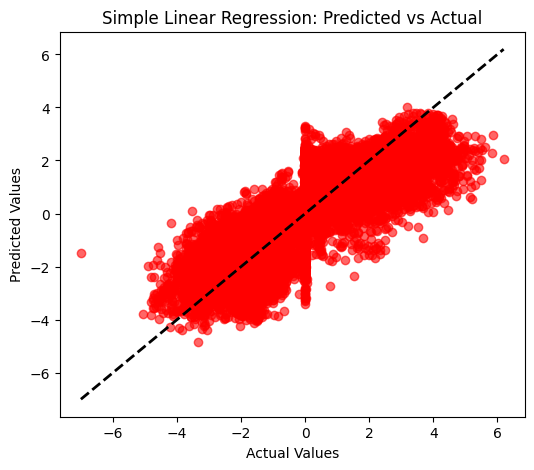

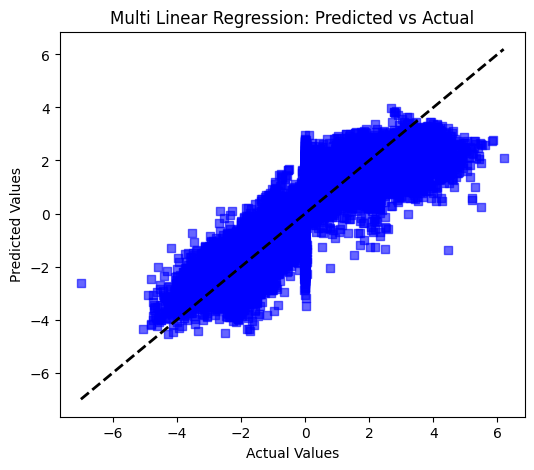

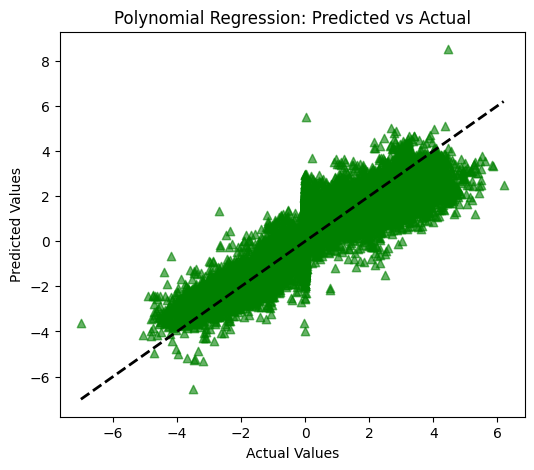

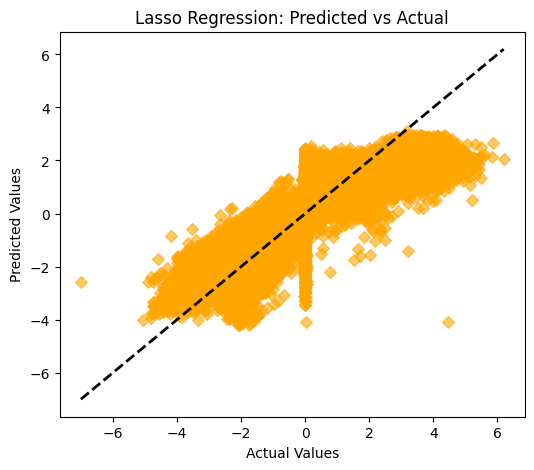

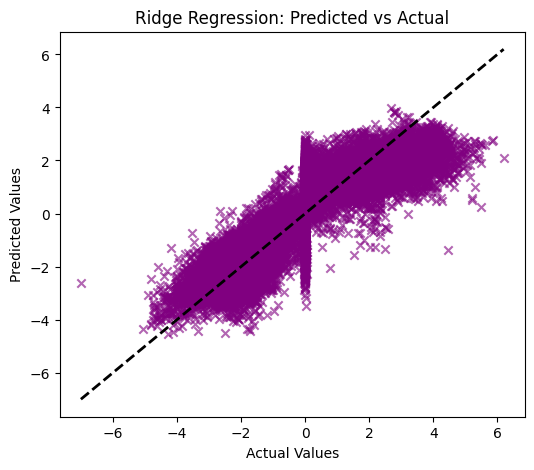

           Model      RMSE        R2
2     Polynomial  0.600324  0.822112
1   Multi Linear  0.805853  0.761209
4          Ridge  0.805854  0.761209
3          Lasso  0.919126  0.727644
0  Simple Linear  1.115168  0.669553


In [576]:
# Dictionary to store evaluation results
results_test = []

for i ,(name, model) in enumerate(models.items()):
    plt.figure(figsize=(6,5))

    if name == "Simple Linear":
        X_te = X_test_simple
    else:
        X_te = X_test_scaled

    # prediciton
    y_pred = model.predict(X_te)
    colors = ["red", "blue", "green", "orange", "purple"]
    markers = ["o", "s", "^", "D", "x"]
    plt.scatter(target_test, y_pred, alpha=0.6, color=colors[i], marker=markers[i])

    # Perfekte Vorhersage-Linie
    plt.plot([target_test.min(), target_test.max()],
             [target_test.min(), target_test.max()], 'k--', lw=2)

    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} Regression: Predicted vs Actual")
    plt.show()


    # RMSE und R² (Regression Metrics)
    rmse = mean_squared_error(target_test, y_pred)
    r2 = r2_score(target_test, y_pred)

    # add the results
    results_test.append({
        "Model": name,
        "RMSE": rmse,
        "R2": r2
    })


# end result of all models
results_df = pd.DataFrame(results_test).sort_values("RMSE")
print(results_df)


## **4. Model Tuning**

### **4.1 Baseline Definition**

The linear regression and regularized models developed in Section 3 serve as the baseline for further optimization.
All preprocessing, feature scaling, and train–test splitting are kept identical to ensure a fair comparison.


In [577]:
# create a dict to store the best models from each estimator
best_models_dict = {}

# add baseline models to model tracker
# list of original baseline features
baseline_feats = list(X_train_scaled.columns)
simple_feat = ['temp_amb']

# Simple Linear
best_models_dict["Baseline Simple Linear"] = {
    "model_obj": model_simple,
    "features": simple_feat,
    "is_optimised": False
}

# Multi Linear
best_models_dict["Baseline Multi Linear"] = {
    "model_obj": model_multi,
    "features": baseline_feats,
    "is_optimised": False
}

# Polynomial
best_models_dict["Baseline Polynomial"] = {
    "model_obj": model_poly,
    "features": list(baseline_feats),
    "is_optimised": False
}

# Lasso
best_models_dict["Baseline Lasso"] = {
    "model_obj": model_lasso,
    "features": baseline_feats,
    "is_optimised": False
}

# Ridge
best_models_dict["Baseline Ridge"] = {
    "model_obj": model_ridge,
    "features": baseline_feats,
    "is_optimised": False
}

### **4.2 Optimization Strategy**
Possibilities to optimise:
* Feature optimization
* Hyperparameter tuning
  
  Mostly applicable to:
  * Polynomial - degree
  * Lasso - alpha
  * Ridge - alpha
* Reverse-cycling targets (heating/cooling) evaluation - separate models depending on if the unit is cooling or heating
* Trying new models not seen in class so far


### **4.2.1 Feature Optimisation**

As the goal is predict the entire building power useage, individual rooms are not relevant. In order to minimise features only one building temperature should be included. Temperature lag in the building thermal mass should also be addressed. 

In [578]:
df_clean.columns

Index(['heating_cooling_power', 'irrad', 'kitchen_active_power', 'setp_371',
       'setp_472', 'setp_474', 'setp_476', 'setp_571', 'setp_573', 'setp_574',
       'shower_471', 'shower_571', 'temp_371', 'temp_472', 'temp_474',
       'temp_476', 'temp_571', 'temp_573', 'temp_574', 'temp_amb',
       'total_active_power', 'delta_T_371', 'delta_T_472', 'delta_T_474',
       'delta_T_476', 'delta_T_571', 'delta_T_573', 'delta_T_574',
       'av_delta_T', 'av_setp', 'weighted_av_delta_T'],
      dtype='object')

In [579]:
# Create multiple lags to test
df_clean['temp_amb_lag_15m'] = df_clean['temp_amb'].shift(1)
df_clean['temp_amb_lag_1h'] = df_clean['temp_amb'].shift(4)
df_clean['temp_amb_lag_2h'] = df_clean['temp_amb'].shift(8).fillna(df_clean['temp_amb'])
df_clean['temp_amb_roll_1h'] = df_clean['temp_amb'].rolling(window=4).mean()

# Check correlations
lag_cols = ['temp_amb', 'temp_amb_lag_15m', 'temp_amb_lag_1h', 'temp_amb_lag_2h', 'temp_amb_roll_1h']
print(df_clean[lag_cols + ['heating_cooling_power']].corr()['heating_cooling_power'])

# best correlation is 2h lag

temp_amb                -0.817003
temp_amb_lag_15m        -0.820207
temp_amb_lag_1h         -0.827334
temp_amb_lag_2h         -0.831610
temp_amb_roll_1h        -0.822894
heating_cooling_power    1.000000
Name: heating_cooling_power, dtype: float64


In [580]:
df_clean['showers'] = df_clean['shower_471'] + df_clean['shower_571']

In [581]:
# find and compare correlation of dataset including new features
all_correlations = df_clean.corr()

# sort the strongest positive correlations to the top. Values to be |x| so -ve can be compared with +ve
all_correlations[['heating_cooling_power']].abs().sort_values(by='heating_cooling_power', ascending=False)

,heating_cooling_power
heating_cooling_power,1.000000
temp_amb_lag_2h,0.831610
temp_amb_lag_1h,0.827334
temp_amb_roll_1h,0.822894
temp_amb_lag_15m,0.820207
temp_amb,0.817003
temp_574,0.780272
temp_476,0.773572
temp_573,0.771764
temp_474,0.758401


In [582]:
# select relevant features from the correlations (generally one of each category), listed in order of correlation
relevant_feats = ['temp_amb_lag_2h', 'av_delta_T', 'irrad', 'total_active_power', 'showers', 'heating_cooling_power']
df_opt = df_clean[relevant_feats]
df_opt

,temp_amb_lag_2h,av_delta_T,irrad,total_active_power,showers,heating_cooling_power
time,,,,,,
2019-07-01 00:00:00,25.926667,-7.071429,0.0,0.575526,0.0,-3.330995
2019-07-01 00:15:00,25.586667,-7.042857,0.0,0.689346,0.0,-3.087947
2019-07-01 00:30:00,25.373333,-7.000000,0.0,0.675612,0.0,-3.441945
2019-07-01 00:45:00,25.333333,-6.995238,0.0,0.566832,0.0,-3.274495
2019-07-01 01:00:00,24.900000,-6.861905,0.0,0.481446,0.0,-3.298245
...,...,...,...,...,...,...
2023-06-29 22:45:00,21.140000,-5.476190,0.0,1.048530,0.0,-2.227025
2023-06-29 23:00:00,20.680000,-5.404762,0.0,0.961422,0.0,-2.174749
2023-06-29 23:15:00,20.466667,-5.357143,0.0,1.007874,0.0,-2.051341


In [583]:
# set different selections of features to test performance on models - assume correlation will dictate greatest effect
feature_set = {
    'feat_set_1': ['temp_amb_lag_2h'],
    'feat_set_2': ['temp_amb_lag_2h', 'av_delta_T'],
    'feat_set_3': ['temp_amb_lag_2h', 'av_delta_T', 'irrad'],
    'feat_set_4': ['temp_amb_lag_2h', 'av_delta_T', 'irrad', 'total_active_power'],
    'feat_set_5': ['temp_amb_lag_2h', 'av_delta_T', 'irrad', 'total_active_power', 'showers']
}

#### **Process New DataFrame**
Process the new DataFrame in the same way as the baseline

In [584]:
# Define new X and y
X_opt = df_opt.drop(columns=['heating_cooling_power'])
y_opt = df_opt['heating_cooling_power']
# Split data (80% Train, 20% Test)
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_opt, y_opt, test_size=0.2, random_state=42)

# scale dataframe the same as the baseline
scaler = StandardScaler()

X_train_opt_scaled = scaler.fit_transform(X_train_opt)
X_test_opt_scaled = scaler.transform(X_test_opt)

# Convert arrays back to DataFrames to preserve column names for analysis and feature selection
X_train_opt_scaled = pd.DataFrame(X_train_opt_scaled, columns=X_opt.columns, index=X_train_opt.index)
X_test_opt_scaled = pd.DataFrame(X_test_opt_scaled, columns=X_opt.columns, index=X_test_opt.index)

### **4.2.2 Hyperparameter Tuning**


**Set Up** relevant variables to organise this section

In [585]:
# setup relevant scoring
scoring = {
    "r2": "r2",
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error"
}

# set up K-Fold - more control over cross-validation splitting than cv=...
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# create a list to track best results from all models
best_scores_opt = []

#### 4.2.2.1 Simple Linear Regression

In [586]:
def tune_simple_linear(
    X_train_scaled,
    y_train,
    cv=kf,
    scoring=scoring
):
    """
    Tune Simple Linear Regression by testing all single features.
    """

    simple_results = []

    # test over different single features
    for col in X_train_scaled.columns:
        X_col = X_train_scaled[[col]]
        model = LinearRegression()

        scores = cross_validate(
            model,
            X_col,
            y_train,
            cv=5,
            scoring=scoring
        )

        simple_results.append({
            "feature": col,
            "r2": scores['test_r2'].mean(),
            "rmse": abs(scores['test_rmse'].mean()),
            "mae": abs(scores['test_mae'].mean())
        })

    simple_df = pd.DataFrame(simple_results)
    best_row = simple_df.sort_values("r2", ascending=False).iloc[0]
    best_model_name = f"Simple Linear ({best_row['feature']})"

    return simple_df, best_row, best_model_name

In [587]:
# call function to check performance
simple_feat_df, best_simple_row, best_simple_name = tune_simple_linear(
    X_train_scaled=X_train_opt_scaled,
    y_train=y_train_opt,
    cv=kf,
    scoring=scoring
)

simple_feat_df

,feature,r2,rmse,mae
0,temp_amb_lag_2h,0.690368,1.015780,0.816237
1,av_delta_T,0.492908,1.299932,1.068065
2,irrad,0.097336,1.734371,1.387005
3,total_active_power,0.087449,1.743846,1.382647
4,showers,-0.000078,1.825564,1.395547


In [588]:
# append best performer to tracker
best_scores_opt.append({
    "Model": 'Simple Linear Regression',
    "Feature_set": best_simple_row['feature'],
    "r2": best_simple_row['r2'],
    "rmse": best_simple_row['rmse'],
    "mae": best_simple_row['mae']
})

In [589]:
# initialise best simple regression model
model_simple_best = LinearRegression(fit_intercept=True)
model_simple_best.fit(X_train_opt_scaled[[best_simple_row['feature']]], y_train_opt)

# add to model dictionary
best_models_dict['Simple Linear Regression'] = {
    'model_obj': model_simple_best,
    'features': [best_simple_row['feature']],
    'is_optimised': True
}

#### 4.2.2.2 Multilinear Regression

In [590]:
def tune_multi_linear(
    X_train_scaled,
    y_train,
    feature_set=feature_set,
    cv=kf,
    scoring=scoring
):
    """
    Tune Multiple Linear Regression over feature sets.
    """

    # setup parameter grid to search through available hyperparameters
    multi_param_grid = {
        "fit_intercept": [True, False]
    }

    # setup a list to store results for the feature set comparison
    multi_feat_results = []

    for set_name, features in feature_set.items():
        loop_X = X_train_scaled[features]


        grid_multi = GridSearchCV(
            LinearRegression(),
            multi_param_grid,
            cv=cv,
            scoring=scoring,
            refit='r2'          # refit='r2' tells GridSearchCV which metric to use to pick the "best" model
        )

        grid_multi.fit(loop_X, y_train)

        best_index = grid_multi.best_index_

        multi_feat_results.append({
            "Feature Set": set_name,
            "Num Features": len(features),
            "r2": grid_multi.cv_results_['mean_test_r2'][best_index],
            "rmse": abs(grid_multi.cv_results_['mean_test_rmse'][best_index]),
            "mae": abs(grid_multi.cv_results_['mean_test_mae'][best_index]),
            "Best Intercept": grid_multi.best_params_['fit_intercept']
        })
    multi_df = pd.DataFrame(multi_feat_results)
    best_row = multi_df.sort_values("r2", ascending=False).iloc[0]
    best_model_name = "Multiple Linear Regression"

    return multi_df, best_row, best_model_name


In [591]:
# call function to check performance
multi_feat_df, best_multi_row, best_multi_name = tune_multi_linear(
    X_train_scaled=X_train_opt_scaled,
    y_train=y_train_opt,
    feature_set=feature_set,
    cv=kf,
    scoring=scoring
)

multi_feat_df

,Feature Set,Num Features,r2,rmse,mae,Best Intercept
0,feat_set_1,1,0.690359,1.015785,0.816230,True
1,feat_set_2,2,0.725566,0.956293,0.766567,True
2,feat_set_3,3,0.725671,0.956110,0.765844,True
3,feat_set_4,4,0.726436,0.954776,0.764490,True
4,feat_set_5,5,0.726434,0.954780,0.764486,True


In [592]:
# add to tracker
best_scores_opt.append({
    "Model": 'Multilinear Regression',
    "Feature_set": best_multi_row["Feature Set"],
    "r2": best_multi_row["r2"],
    "rmse": best_multi_row["rmse"],
    "mae": best_multi_row["mae"]
})

In [593]:
# initialise best multilinear regression model
best_multi_feats = feature_set[best_multi_row["Feature Set"]]
model_multi_best = LinearRegression(fit_intercept=best_multi_row["Best Intercept"])
model_multi_best.fit(X_train_opt_scaled[best_multi_feats], y_train_opt)

# add to model dictionary
best_models_dict['Multilinear Regression'] = {
    'model_obj': model_multi_best,
    'features': best_multi_feats,
    'is_optimised': True
}

#### 4.2.2.3 Polynomial Regression

In [594]:
def tune_polynomial(
    X_train_scaled,
    y_train,
    feature_set=feature_set,
    cv=kf,
    scoring=scoring
):
    """
    Tune Polynomial Regression (interaction-only).
    """

    poly_pipe = make_pipeline(
        PolynomialFeatures(interaction_only=True),  # intereaction only saves RAM by not generating redundant features
        LinearRegression()
    )

    poly_param_grid = {
        "polynomialfeatures__degree": [1, 2, 3, 4],
        "linearregression__fit_intercept": [True, False]
    }
    poly_feat_results = []
    best_r2 = -np.inf
    best_pipeline = None

    for set_name, features in feature_set.items():
        loop_X = X_train_scaled[features]

        grid_poly = GridSearchCV(
            poly_pipe,
            poly_param_grid,
            cv=cv,
            scoring=scoring,
            refit='r2',
            n_jobs=-1
        )

        grid_poly.fit(loop_X, y_train)
        best_index = grid_poly.best_index_
        mean_r2 = grid_poly.cv_results_['mean_test_r2'][best_index]


        poly_feat_results.append({
            "Feature Set": set_name,
            "Num Features": len(features),
            "Degree": grid_poly.best_params_['polynomialfeatures__degree'],
            "r2": grid_poly.cv_results_['mean_test_r2'][best_index],
            "rmse": abs(grid_poly.cv_results_['mean_test_rmse'][best_index]),
            "mae": abs(grid_poly.cv_results_['mean_test_mae'][best_index]),
        })

        # Track best pipeline
        if mean_r2 > best_r2:
            best_r2 = mean_r2
            best_pipeline = grid_poly.best_estimator_

    poly_df = pd.DataFrame(poly_feat_results)
    best_row = poly_df.sort_values("r2", ascending=False).iloc[0]
    best_model_name = f"Polynomial (deg={best_row['Degree']})"

    return poly_df, best_row, best_model_name, best_pipeline

In [595]:
# call function to check performance
poly_feat_df, best_poly_row, best_poly_name, model_poly_best = tune_polynomial(
    X_train_scaled=X_train_opt_scaled,
    y_train=y_train_opt,
    feature_set=feature_set,
    cv=kf,
    scoring=scoring
)

poly_feat_df

/home/von_riecken/.pyenv/versions/3.14.0/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/von_riecken/.pyenv/versions/3.14.0/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/von_riecken/.pyenv/versions/3.14.0/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30

,Feature Set,Num Features,Degree,r2,rmse,mae
0,feat_set_1,1,1,0.690359,1.015785,0.816230
1,feat_set_2,2,2,0.745165,0.921508,0.730778
2,feat_set_3,3,3,0.761606,0.891288,0.698173
3,feat_set_4,4,4,0.765418,0.884138,0.690120
4,feat_set_5,5,4,0.765305,0.884350,0.690267


In [596]:
best_poly_row = poly_feat_df.sort_values("r2", ascending=False).iloc[0]

best_scores_opt.append({
    "Model": best_poly_name,
    "Feature_set": best_poly_row["Feature Set"],
    "r2": best_poly_row["r2"],
    "rmse": best_poly_row["rmse"],
    "mae": best_poly_row["mae"]
})

In [597]:
# initialise best polynomial regression model
best_poly_feats = feature_set[best_poly_row["Feature Set"]]

# add to model dictionary
poly_label = best_poly_name
best_models_dict[poly_label] = {
    'model_obj': model_poly_best,
    'features': best_poly_feats,
    'is_optimised': True
}

#### 4.2.2.4 Lasso Regularisation

In [598]:
# setup parameter grid for Lasso
def tune_lasso(
    X_train_scaled,
    y_train,
    feature_set=feature_set,
    cv=kf,
    scoring=scoring,
    alpha_grid=None,
    random_state=42
):
    """
    Tune Lasso Regression over feature sets.
    """
    if alpha_grid is None:
        lasso_param_grid = {
            "alpha": [0.01, 0.1, 1.0, 10.0],
            "fit_intercept": [True, False]
        }


    lasso_feat_results = []

    for set_name, features in feature_set.items():
        loop_X = X_train_scaled[features]

        grid_lasso = GridSearchCV(
            Lasso(random_state=random_state),
            lasso_param_grid,
            cv=cv,
            scoring=scoring,
            refit='r2'
        )

        grid_lasso.fit(loop_X, y_train)
        best_index = grid_lasso.best_index_

        lasso_feat_results.append({
            "Feature Set": set_name,
            "Alpha": grid_lasso.best_params_['alpha'],
            "r2": grid_lasso.cv_results_['mean_test_r2'][best_index],
            "rmse": abs(grid_lasso.cv_results_['mean_test_rmse'][best_index]),
            "mae": abs(grid_lasso.cv_results_['mean_test_mae'][best_index]),
        })

    lasso_df = pd.DataFrame(lasso_feat_results)
    best_row = lasso_df.sort_values("r2", ascending=False).iloc[0]
    best_model_name = f"Lasso (alpha={best_row['Alpha']})"

    return lasso_df, best_row, best_model_name

In [599]:
# call function to check performance
lasso_feat_df, best_lasso_row, best_lasso_name = tune_lasso(
    X_train_scaled=X_train_opt_scaled,
    y_train=y_train_opt,
    feature_set=feature_set,
    cv=kf,
    scoring=scoring
)

lasso_feat_df

,Feature Set,Alpha,r2,rmse,mae
0,feat_set_1,0.01,0.690329,1.015833,0.816646
1,feat_set_2,0.01,0.725531,0.956355,0.766833
2,feat_set_3,0.01,0.725568,0.956290,0.766648
3,feat_set_4,0.01,0.725568,0.956290,0.766648
4,feat_set_5,0.01,0.725568,0.956290,0.766648


In [600]:
# Find and track the best Lasso performer
best_lasso_row = lasso_feat_df.sort_values("r2", ascending=False).iloc[0]

best_scores_opt.append({
    "Model": best_lasso_name,
    "Feature_set": best_lasso_row["Feature Set"],
    "r2": best_lasso_row["r2"],
    "rmse": best_lasso_row["rmse"],
    "mae": best_lasso_row["mae"]
})

In [601]:
# initialise best lasso regularisation model
best_lasso_feats = feature_set[best_lasso_row["Feature Set"]]
model_lasso_best = Lasso(alpha=best_lasso_row["Alpha"], random_state=42)
model_lasso_best.fit(X_train_opt_scaled[best_lasso_feats], y_train_opt)

# add to model dictionary
lasso_label = f'Lasso (alpha={best_lasso_row["Alpha"]})'
best_models_dict[lasso_label] = {
    'model_obj': model_lasso_best,
    'features': best_lasso_feats,
    'is_optimised': True
}

#### 4.2.2.5 Ridge Regularisation

In [602]:
def tune_ridge(
    X_train_scaled,
    y_train,
    feature_set=feature_set,
    cv=kf,
    scoring=scoring,
    alpha_grid=None,
    random_state=42
):
    # setup parameter grid for Ridge
    if alpha_grid is None:
        ridge_param_grid = {
            "alpha": [0.1, 1.0, 10.0, 100.0],
            "fit_intercept": [True, False]
        }

    ridge_feat_results = []

    for set_name, features in feature_set.items():
        loop_X = X_train_scaled[features]

        grid_ridge = GridSearchCV(
            Ridge(random_state=random_state),
            param_grid=ridge_param_grid,
            cv=cv,
            scoring=scoring,
            refit='r2'
        )

        grid_ridge.fit(loop_X, y_train)
        best_index = grid_ridge.best_index_

        ridge_feat_results.append({
            "Feature Set": set_name,
            "Alpha": grid_ridge.best_params_['alpha'],
            "r2": grid_ridge.cv_results_['mean_test_r2'][best_index],
            "rmse": abs(grid_ridge.cv_results_['mean_test_rmse'][best_index]),
            "mae": abs(grid_ridge.cv_results_['mean_test_mae'][best_index]),
        })

    ridge_feat_df = pd.DataFrame(ridge_feat_results)
    best_row = ridge_feat_df.sort_values("r2", ascending=False).iloc[0]

    best_model_name = f'Ridge (alpha={best_row["Alpha"]})'

    return ridge_feat_df, best_row, best_model_name

In [603]:
# call function to check performance
ridge_feat_df, best_ridge_row, best_ridge_name = tune_ridge(
    X_train_scaled=X_train_opt_scaled,
    y_train=y_train_opt,
    feature_set=feature_set,
    cv=kf,
    scoring=scoring
)

ridge_feat_df

,Feature Set,Alpha,r2,rmse,mae
0,feat_set_1,1.0,0.690359,1.015785,0.816231
1,feat_set_2,1.0,0.725566,0.956293,0.766567
2,feat_set_3,1.0,0.725671,0.956110,0.765845
3,feat_set_4,10.0,0.726436,0.954776,0.764498
4,feat_set_5,10.0,0.726434,0.954780,0.764495


In [604]:
# find and track the best Ridge performer
best_ridge_row = ridge_feat_df.sort_values("r2", ascending=False).iloc[0]

best_scores_opt.append({
    "Model": best_ridge_name,
    "Feature_set": best_ridge_row["Feature Set"],
    "r2": best_ridge_row["r2"],
    "rmse": best_ridge_row["rmse"],
    "mae": best_ridge_row["mae"]
})

In [605]:
# initialise best ridge regularisation model
best_ridge_feats = feature_set[best_ridge_row["Feature Set"]]
model_ridge_best = Ridge(alpha=best_ridge_row["Alpha"], random_state=42)
model_ridge_best.fit(X_train_opt_scaled[best_ridge_feats], y_train_opt)

# add to model dictionary
ridge_label = f'Ridge (alpha={best_ridge_row["Alpha"]})'
best_models_dict[ridge_label] = {
    'model_obj': model_ridge_best,
    'features': best_ridge_feats,
    'is_optimised': True
}

In [606]:
# Create the optimized summary
df_optimized = pd.DataFrame(best_scores_opt)
df_optimized['Category'] = 'Optimized'

# Prepare baseline (making column names match)
df_baseline = results_df.copy()
df_baseline.rename(columns={'Model': 'Model', 'R2': 'r2', 'RMSE': 'rmse'}, inplace=True)
df_baseline['Category'] = 'Baseline (Raw)'

# Combine and compare
comparison_table = pd.concat([df_optimized, df_baseline], ignore_index=True)
comparison_table = comparison_table.sort_values(by='r2', ascending=False)

# Display results
display(comparison_table[['Category', 'Model', 'r2', 'rmse']])

,Category,Model,r2,rmse
5,Baseline (Raw),Polynomial,0.822112,0.600324
2,Optimized,Polynomial (deg=4),0.765418,0.884138
6,Baseline (Raw),Multi Linear,0.761209,0.805853
7,Baseline (Raw),Ridge,0.761209,0.805854
8,Baseline (Raw),Lasso,0.727644,0.919126
4,Optimized,Ridge (alpha=10.0),0.726436,0.954776
1,Optimized,Multilinear Regression,0.726436,0.954776
3,Optimized,Lasso (alpha=0.01),0.725568,0.956290
0,Optimized,Simple Linear Regression,0.690368,1.015780
9,Baseline (Raw),Simple Linear,0.669553,1.115168


In [607]:
pd.DataFrame(best_models_dict)

,Baseline Simple Linear,Baseline Multi Linear,Baseline Polynomial,Baseline Lasso,Baseline Ridge,Simple Linear Regression,Multilinear Regression,Polynomial (deg=4),Lasso (alpha=0.01),Ridge (alpha=10.0)
model_obj,LinearRegression(),LinearRegression(),"(PolynomialFeatures(), LinearRegression())","Lasso(alpha=0.1, random_state=42)",Ridge(random_state=42),LinearRegression(),LinearRegression(fit_intercept=np.True_),"(PolynomialFeatures(degree=4, interaction_only...","Lasso(alpha=np.float64(0.01), random_state=42)","Ridge(alpha=np.float64(10.0), random_state=42)"
features,[temp_amb],"[irrad, kitchen_active_power, setp_371, setp_4...","[irrad, kitchen_active_power, setp_371, setp_4...","[irrad, kitchen_active_power, setp_371, setp_4...","[irrad, kitchen_active_power, setp_371, setp_4...",[temp_amb_lag_2h],"[temp_amb_lag_2h, av_delta_T, irrad, total_act...","[temp_amb_lag_2h, av_delta_T, irrad, total_act...","[temp_amb_lag_2h, av_delta_T, irrad]","[temp_amb_lag_2h, av_delta_T, irrad, total_act..."
is_optimised,False,False,False,False,False,True,True,True,True,True


### 4.2.3 More Specific Targets

As the unit must run either heating or cooling, not both, we try to train models to predict the power output of each cycle

In [608]:
# split the data into heating, cooling or off
df_heating = df_opt[df_opt['heating_cooling_power']>0]
df_cooling = df_opt[df_opt['heating_cooling_power']<0]
df_off = df_opt[df_opt['heating_cooling_power']==0]

In [609]:
# process split dfs: train, test split and scale
def process_thermal_data(
    df,
    target_col='heating_cooling_power',
    feature_set=feature_set,
    cv=kf,
    scoring=scoring
):
    """
    Processes a subset of data (Heating or Cooling or Off) through the full
    optimization pipeline and returns the best models.
    Returns
    -------
    models_dict : dict
        Trained final models with selected features
    best_results : list
        Best CV scores for each estimator
    X_test_scaled : pd.DataFrame
        Scaled test features
    y_test : pd.Series
        Test target values
    """
    # split and scale
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

    # model tracking storage
    best_results = []
    models_dict = {}

    # --- Simple Linear ---
    simple_df, simple_best, simple_name = tune_simple_linear(
        X_train_scaled,
        y_train,
        cv=cv,
        scoring=scoring
    )

    best_results.append({
        "Model": simple_name,
        "Feature_set": simple_best["feature"],
        "r2": simple_best["r2"],
        "rmse": simple_best["rmse"],
        "mae": simple_best["mae"]
    })

    model_simple = LinearRegression()
    model_simple.fit(
        X_train_scaled[[simple_best["feature"]]],
        y_train
    )

    models_dict["Simple Linear"] = {
        "model_obj": model_simple,
        "features": [simple_best["feature"]]
    }

    # --- Multiple Linear ---
    multi_df, multi_best, multi_name = tune_multi_linear(
        X_train_scaled,
        y_train,
        feature_set=feature_set,
        cv=cv,
        scoring=scoring
    )

    best_results.append({
        "Model": multi_name,
        "Feature_set": multi_best["Feature Set"],
        "r2": multi_best["r2"],
        "rmse": multi_best["rmse"],
        "mae": multi_best["mae"]
    })

    model_multi = LinearRegression(
        fit_intercept=multi_best["Best Intercept"]
    )
    model_multi.fit(
        X_train_scaled[feature_set[multi_best["Feature Set"]]],
        y_train
    )

    models_dict["Multi Linear"] = {
        "model_obj": model_multi,
        "features": feature_set[multi_best["Feature Set"]]
    }

    # --- Polynomial ---
    poly_df, poly_best, poly_name, poly_pipe = tune_polynomial(
        X_train_scaled,
        y_train,
        feature_set,
        cv,
        scoring
    )

    poly_feats = feature_set[poly_best["Feature Set"]]
    model_poly = make_pipeline(
        PolynomialFeatures(
            degree=int(poly_best["Degree"]),
            interaction_only=True
        ),
        LinearRegression()
    )
    model_poly.fit(X_train_scaled[poly_feats], y_train)

    best_results.append({
        "Model": poly_name,
        "Feature_set": poly_best["Feature Set"],
        "r2": poly_best["r2"],
        "rmse": poly_best["rmse"],
        "mae": poly_best["mae"]
    })

    models_dict["Polynomial"] = {
        "model_obj": model_poly,
        "features": feature_set[poly_best["Feature Set"]]
    }

    # --- Lasso ---
    lasso_df, lasso_best, lasso_name = tune_lasso(
        X_train_scaled,
        y_train,
        feature_set=feature_set,
        cv=cv,
        scoring=scoring
    )

    best_results.append({
        "Model": lasso_name,
        "Feature_set": lasso_best["Feature Set"],
        "r2": lasso_best["r2"],
        "rmse": lasso_best["rmse"],
        "mae": lasso_best["mae"]
    })

    model_lasso = Lasso(
        alpha=lasso_best["Alpha"],
        max_iter=10000,
        random_state=42
    )
    model_lasso.fit(
        X_train_scaled[feature_set[lasso_best["Feature Set"]]],
        y_train
    )

    models_dict["Lasso"] = {
        "model_obj": model_lasso,
        "features": feature_set[lasso_best["Feature Set"]]
    }

    # --- Ridge ---
    ridge_df, ridge_best, ridge_name = tune_ridge(
        X_train_scaled,
        y_train,
        feature_set=feature_set,
        cv=cv,
        scoring=scoring
    )

    best_results.append({
        "Model": ridge_name,
        "Feature_set": ridge_best["Feature Set"],
        "r2": ridge_best["r2"],
        "rmse": ridge_best["rmse"],
        "mae": ridge_best["mae"]
    })

    model_ridge = Ridge(
        alpha=ridge_best["Alpha"],
        random_state=42
    )
    model_ridge.fit(
        X_train_scaled[feature_set[ridge_best["Feature Set"]]],
        y_train
    )

    models_dict["Ridge"] = {
        "model_obj": model_ridge,
        "features": feature_set[ridge_best["Feature Set"]]
    }
    return models_dict, best_results, X_test_scaled, y_test


In [610]:
# execute for different operating conditions
heat_models, heat_stats, X_test_heat, y_test_heat = process_thermal_data(df_heating, 'heating_cooling_power', feature_set, kf, scoring)
cool_models, cool_stats, X_test_cool, y_test_cool = process_thermal_data(df_cooling, 'heating_cooling_power', feature_set, kf, scoring)
off_models, off_stats, X_test_off, y_test_off = process_thermal_data(df_off, 'heating_cooling_power', feature_set, kf, scoring)

/home/von_riecken/.pyenv/versions/3.14.0/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/von_riecken/.pyenv/versions/3.14.0/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/von_riecken/.pyenv/versions/3.14.0/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

In [611]:
pd.DataFrame(heat_stats)

,Model,Feature_set,r2,rmse,mae
0,Simple Linear (temp_amb_lag_2h),temp_amb_lag_2h,0.270497,0.955496,0.754940
1,Multiple Linear Regression,feat_set_4,0.357890,0.896361,0.703057
2,Polynomial (deg=4),feat_set_4,0.388549,0.874681,0.683820
3,Lasso (alpha=0.01),feat_set_5,0.357693,0.896503,0.703863
4,Ridge (alpha=10.0),feat_set_4,0.357890,0.896361,0.703072


In [612]:
pd.DataFrame(cool_stats)

,Model,Feature_set,r2,rmse,mae
0,Simple Linear (temp_amb_lag_2h),temp_amb_lag_2h,0.348210,0.734776,0.592071
1,Multiple Linear Regression,feat_set_4,0.452312,0.673539,0.535956
2,Polynomial (deg=4),feat_set_4,0.462152,0.667469,0.530673
3,Lasso (alpha=0.01),feat_set_3,0.451830,0.673838,0.536591
4,Ridge (alpha=10.0),feat_set_4,0.452312,0.673539,0.535959


In [613]:
pd.DataFrame(off_stats)

,Model,Feature_set,r2,rmse,mae
0,Simple Linear (temp_amb_lag_2h),temp_amb_lag_2h,1.0,0.0,0.0
1,Multiple Linear Regression,feat_set_1,1.0,0.0,0.0
2,Polynomial (deg=1),feat_set_1,1.0,0.0,0.0
3,Lasso (alpha=0.01),feat_set_1,1.0,0.0,0.0
4,Ridge (alpha=0.1),feat_set_1,1.0,0.0,0.0


**Reverse Cycle Results**

Best performing heating cycle returned an R2 of 0.39, cooling of 0.46 abd off of 1.0, though the off case off fitting to 0 is mathematically 0. 

Separating heating cycle, cooling and off cycle didn't function as anticipated. It would be worth looking into an initial classification regression to label the cycle of the unit and then fitting to the specific label. 

### 4.2.4 Other Models

In this section AI will do all the work, so the scores will not be taken into consideration. 



#### 4.2.4.1 Random Tree Regressor

Random tree regressor builds a multitude of decision trees during training and outputs the average prediction of all the individual trees, generally improving accuracy and preventing overfitting to noise. 

In [614]:
from sklearn.ensemble import RandomForestRegressor

def tune_rf(X_train, y_train, feature_set, kf, scoring):
    rf_param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [5]
    }

    rf_results = []
    for set_name, features in feature_set.items():
        grid = GridSearchCV(
            RandomForestRegressor(random_state=42),
            rf_param_grid,
            cv=kf,
            scoring=scoring,
            refit='r2',
            n_jobs=-1
        )

        X_subset = X_train[features]
        grid.fit(X_subset, y_train)

        idx = grid.best_index_
        rf_results.append({
            "Feature Set": set_name,
            "Params": grid.best_params_,
            "r2": grid.cv_results_['mean_test_r2'][idx],
            "rmse": abs(grid.cv_results_['mean_test_rmse'][idx])
        })

    rf_df = pd.DataFrame(rf_results).sort_values("r2", ascending=False)
    best_row = rf_df.iloc[0]

    return rf_df, best_row, grid.best_estimator_

#### 4.2.4.2 Gradient Boosting

A Gradient Boosting Regressor builds trees sequentially, where each new tree specifically tries to correct the errors made by the previous ones. By focusing on the "mistakes" of earlier iterations, it minimizes a loss function step-by-step to achieve high predictive precision for complex, non-linear patterns.

In [615]:
from sklearn.ensemble import GradientBoostingRegressor

def tune_gb(X_train, y_train, feature_set, kf, scoring):
    gb_param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.1],
        'max_depth': [3]
    }

    gb_results = []
    for set_name, features in feature_set.items():
        grid = GridSearchCV(
            GradientBoostingRegressor(random_state=42),
            gb_param_grid,
            cv=kf,
            scoring=scoring,
            refit='r2',
            n_jobs=-1
        )

        # Slicing the dataframe once before fitting
        X_subset = X_train[features].copy()
        grid.fit(X_subset, y_train)

        idx = grid.best_index_
        gb_results.append({
            "Feature Set": set_name,
            "r2": grid.cv_results_['mean_test_r2'][idx],
            "rmse": abs(grid.cv_results_['mean_test_rmse'][idx]),
            "params": grid.best_params_
        })

    gb_df = pd.DataFrame(gb_results).sort_values("r2", ascending=False)
    best_row = gb_df.iloc[0]

    return gb_df, best_row, grid.best_estimator_

In [616]:
# tune random_forest
rf_df, rf_best, rf_model = tune_rf(X_train_opt_scaled, target_train, feature_set, kf, scoring)

In [617]:
pd.DataFrame(rf_best)

,3
Feature Set,feat_set_4
Params,"{'max_depth': 10, 'min_samples_split': 5, 'n_e..."
r2,0.823594
rmse,0.766706


In [618]:
# tune gradient boost
gb_df, gb_best, gb_model = tune_gb(X_train_opt_scaled, target_train, feature_set, kf, scoring)

In [619]:
pd.DataFrame(gb_best)

,3
Feature Set,feat_set_4
r2,0.809834
rmse,0.796045
params,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


From an initial look without deep-diving into model performance, the random forest regressor scored an r2 of 0.82 and the gradient boost scored an r2 of 0.81. These models both out-performed the linear regressions (except baseline polynomial) we used so the next step would be to dive deeper into these models and also look for others such as Support Vector Regression (SVR), KNN-Regressor, XGBoost or LightGBM. Ensemble stacking should also be looked into.

However, as discussed, these models are not currently included in this project's performance evaluations. 

### 4.2.5 Further Steps For Tuning

Options to improve model performance include:
* training an initial classification to identify which cycle the unit is on
* training more complex regression models - including ensemble stacking
* try more feature combinations - e.g.  weighted average delta T wasn't used only due to correlation, not testing
* integrate time-series factors - such as whether certain times induce more errors  

### Combining baseline models to compare with optimised

## **5. Evaluation & Model Selection**



**To ensure our model selection is robust and not just lucky on a specific data split, we performed 5-Fold Cross-Validation on all candidate models.**

**Metric**: We used R² to penalize large errors effectively.

**Stability**: The standard deviation (Stability (Std)) indicates how consistent the model is across different data folds.

**Comparison**: This step allows us to objectively compare the simple baseline against complex regularized models (Lasso/Ridge) to see if the added complexity actually yields better generalization.

In [631]:
pd.DataFrame(best_models_dict)

,Baseline Simple Linear,Baseline Multi Linear,Baseline Polynomial,Baseline Lasso,Baseline Ridge,Simple Linear Regression,Multilinear Regression,Polynomial (deg=4),Lasso (alpha=0.01),Ridge (alpha=10.0)
model_obj,LinearRegression(),LinearRegression(),"(PolynomialFeatures(), LinearRegression())","Lasso(alpha=0.1, random_state=42)",Ridge(random_state=42),LinearRegression(),LinearRegression(fit_intercept=np.True_),"(PolynomialFeatures(degree=4, interaction_only...","Lasso(alpha=np.float64(0.01), random_state=42)","Ridge(alpha=np.float64(10.0), random_state=42)"
features,[temp_amb],"[irrad, kitchen_active_power, setp_371, setp_4...","[irrad, kitchen_active_power, setp_371, setp_4...","[irrad, kitchen_active_power, setp_371, setp_4...","[irrad, kitchen_active_power, setp_371, setp_4...",[temp_amb_lag_2h],"[temp_amb_lag_2h, av_delta_T, irrad, total_act...","[temp_amb_lag_2h, av_delta_T, irrad, total_act...","[temp_amb_lag_2h, av_delta_T, irrad]","[temp_amb_lag_2h, av_delta_T, irrad, total_act..."
is_optimised,False,False,False,False,False,True,True,True,True,True


In [632]:
test_results = []

for name, info in best_models_dict.items():
    model = info['model_obj']
    feats = info['features']

    # Select correct test set
    if info.get('is_optimised', False):
        X_test_use = X_test_opt_scaled
        y_test_use = y_test_opt
    else:
        X_test_use = X_test_scaled
        y_test_use = target_test

    # Always let the model handle transformations
    y_pred = model.predict(X_test_use[feats])

    test_results.append({
        "Model": name,
        "Optimized": info.get('is_optimised', False),
        "R2": r2_score(y_test_use, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test_use, y_pred)),
        "MAE": mean_absolute_error(y_test_use, y_pred)
    })

test_results_df = (
    pd.DataFrame(test_results)
    .sort_values("R2", ascending=False)
    .reset_index(drop=True)
)

test_results_df


,Model,Optimized,R2,RMSE,MAE
0,Baseline Polynomial,False,0.822112,0.774806,0.590639
1,Polynomial (deg=4),True,0.767577,0.885642,0.690861
2,Baseline Multi Linear,False,0.761209,0.897693,0.713009
3,Baseline Ridge,False,0.761209,0.897694,0.713010
4,Multilinear Regression,True,0.730161,0.954270,0.763068
5,Ridge (alpha=10.0),True,0.730160,0.954272,0.763077
6,Lasso (alpha=0.01),True,0.729186,0.955992,0.765450
7,Baseline Lasso,False,0.727644,0.958711,0.775504
8,Simple Linear Regression,True,0.696195,1.012551,0.813377
9,Baseline Simple Linear,False,0.669553,1.056015,0.853217


## **6. Final Model Description**

After rigorous evaluation, we selected the **Baseline Polynomial** as our final model.

**1. Performance Metrics:**
* **$R^2$ Score:** `0.82`
    * This indicates that the model explains approx. **[INSERT R2 * 100]%** of the variance in the heating/cooling power.
* **RMSE:** `0.77`
    * On average, the model's prediction deviates by this amount from the actual value.

**2. The Bias-Variance Tradeoff:**
Our selection was driven by finding the optimal balance:



* **Avoiding Underfitting (High Bias):** We rejected the *Simple Linear Model* because its error was too high—it failed to capture the complexity of the data (e.g., non-linear relationships).
* **Avoiding Overfitting (High Variance):** We verified through Cross-Validation that our chosen model is stable. It captures the underlying patterns (e.g., the curve of temperature vs. power) without reacting to random noise in the training data.

**Conclusion:**
This model offers the best **generalization capability**, providing accurate predictions on unseen data while maintaining an interpretable structure.

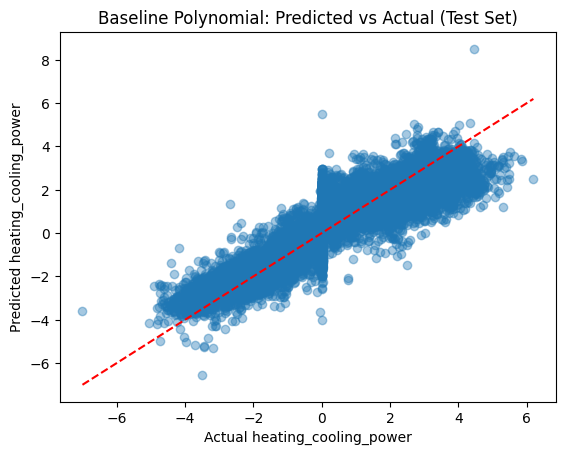

In [633]:
best_row = test_results_df.iloc[0]
best_name = best_row["Model"]

best_model = best_models_dict[best_name]['model_obj']
best_feats = best_models_dict[best_name]['features']

info = best_models_dict[best_name]

if info.get("is_optimised", False):
    X_test_use = X_test_opt_scaled
    y_test_use = y_test_opt
else:
    X_test_use = X_test_scaled
    y_test_use = target_test

y_pred_best = best_model.predict(X_test_use[best_feats])

plt.scatter(y_test_opt, y_pred_best, alpha=0.4)
plt.plot([y_test_opt.min(), y_test_opt.max()],
         [y_test_opt.min(), y_test_opt.max()],
         'r--')

plt.xlabel(f"Actual {target}")
plt.ylabel(f"Predicted {target}")
plt.title(f"{best_name}: Predicted vs Actual (Test Set)")
plt.show()

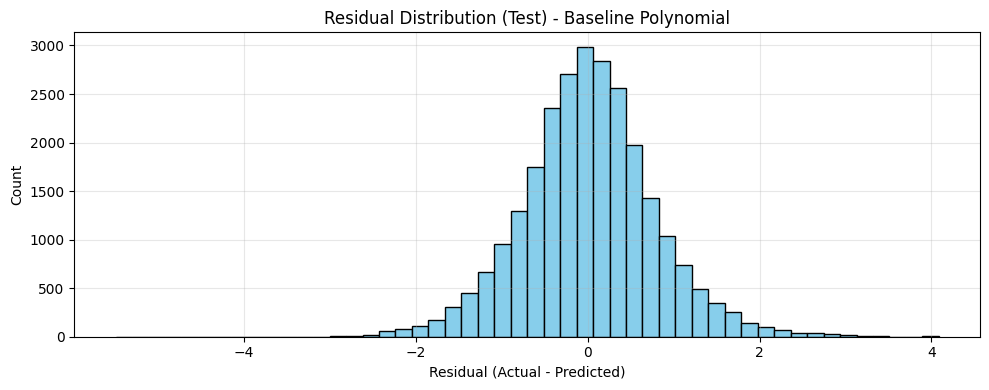

In [634]:
# Residuals
residuals = y_test_opt - y_pred_best

# Plot: Residual histogram
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title(f"Residual Distribution (Test) - {best_name}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


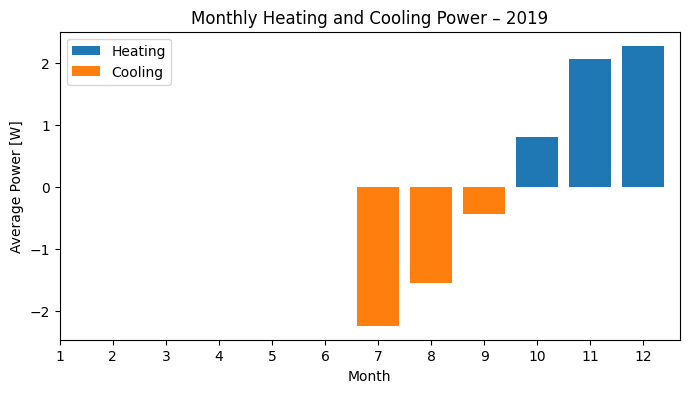

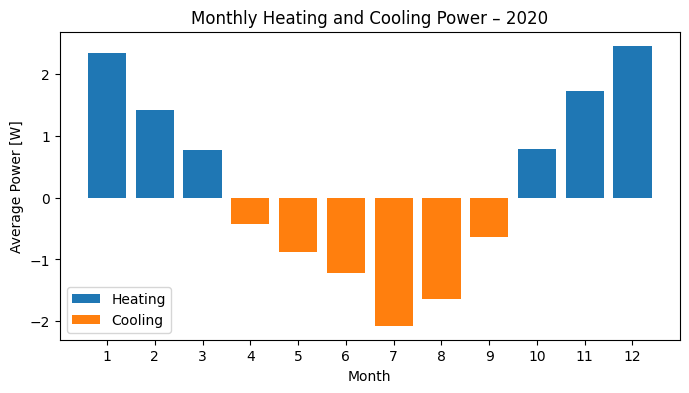

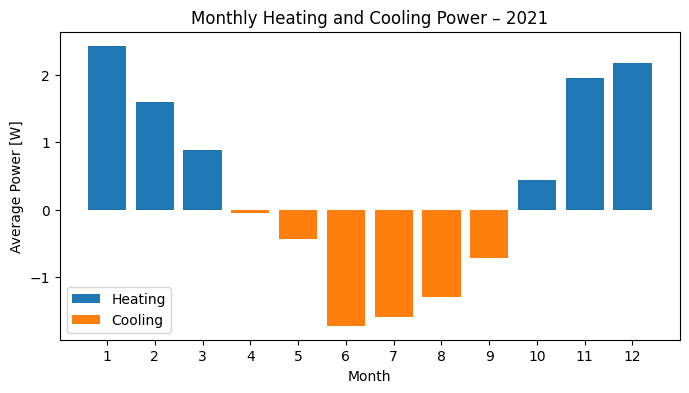

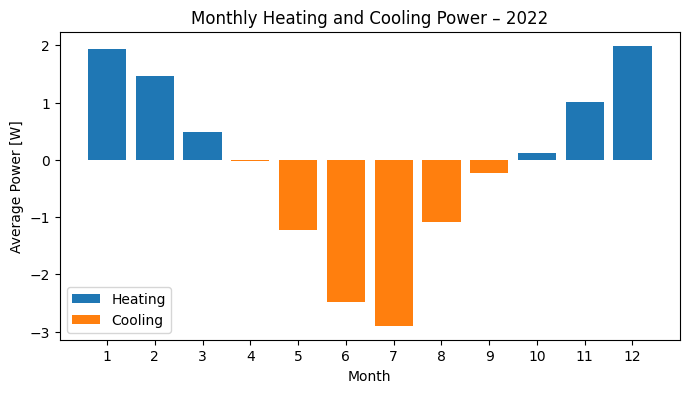

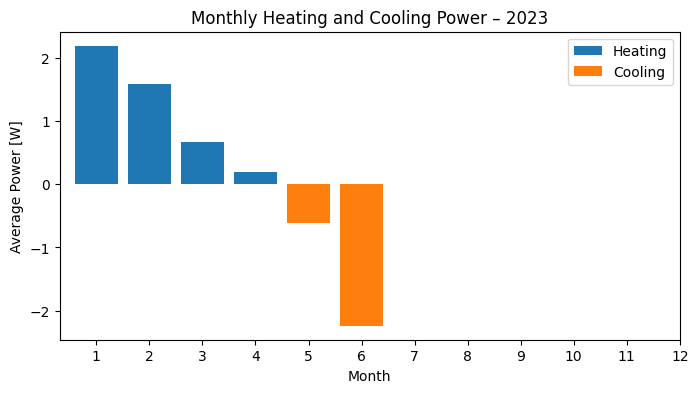

In [635]:
df_plot = df.copy()

df_plot['time'] = pd.to_datetime(df_plot['time'])
df_plot['year'] = df_plot['time'].dt.year
df_plot['month'] = df_plot['time'].dt.month

# Monthly mean
monthly = (
    df_plot
    .groupby(['year', 'month'])['heating_cooling_power']
    .mean()
    .reset_index()
)
years = sorted(monthly['year'].unique())

for y in years:
    data_year = monthly[monthly['year'] == y]

    heating = data_year[data_year['heating_cooling_power'] > 0]
    cooling = data_year[data_year['heating_cooling_power'] < 0]

    plt.figure(figsize=(8,4))

    plt.bar(
        heating['month'],
        heating['heating_cooling_power'],
        label='Heating'
    )

    plt.bar(
        cooling['month'],
        cooling['heating_cooling_power'],
        label='Cooling'
    )

    plt.title(f"Monthly Heating and Cooling Power – {y}")
    plt.xlabel("Month")
    plt.ylabel("Average Power [W]")
    plt.xticks(range(1,13))
    plt.legend()
    plt.show()


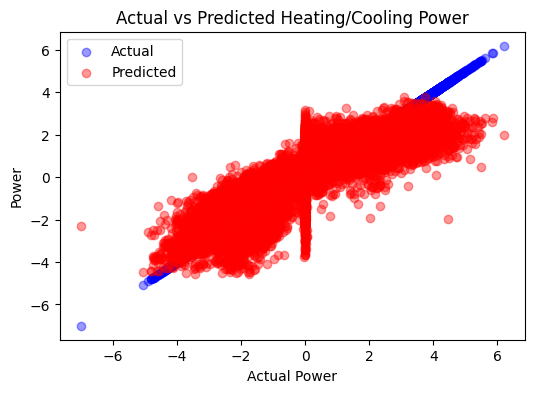

In [636]:
plt.figure(figsize=(6,4))

# Actual values
plt.scatter(
    y_test_opt,
    y_test_opt,
    color='blue',
    alpha=0.4,
    label='Actual'
)

# Predicted values
plt.scatter(
    y_test_opt,
    y_pred,
    color='red',
    alpha=0.4,
    label='Predicted'
)

plt.xlabel("Actual Power")
plt.ylabel("Power")
plt.title("Actual vs Predicted Heating/Cooling Power")
plt.legend()
plt.show()


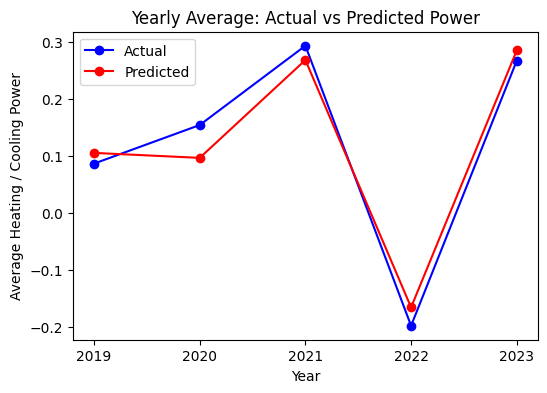

In [637]:
df_plot = pd.DataFrame({
    "time": X_test_opt_scaled.index,
    "Actual": y_test_opt.values,
    "Predicted": y_pred_best
})

df_plot['time'] = pd.to_datetime(df_plot['time'])
df_plot['year'] = df_plot['time'].dt.year
df_plot['month'] = df_plot['time'].dt.month

df_plot['Actual'] = y_test_opt.values
df_plot['Predicted'] = y_pred_best

yearly_avg = (
    df_plot
    .groupby('year')[['Actual', 'Predicted']]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))

plt.plot(
    yearly_avg['year'],
    yearly_avg['Actual'],
    marker='o',
    label='Actual',
    color='blue'
)

plt.plot(
    yearly_avg['year'],
    yearly_avg['Predicted'],
    marker='o',
    label='Predicted',
    color='red'
)

plt.xlabel("Year")
plt.ylabel("Average Heating / Cooling Power")
plt.title("Yearly Average: Actual vs Predicted Power")

plt.xticks(yearly_avg['year'])
plt.legend()
plt.show()


# **A. Appendix**

### **A.1 Contribution Matrix**


In [638]:
contribution_matrix = pd.DataFrame(
    {
        "Aya Abd Alahi": [
            "2.3 Visual Exploration - Features",
            "2.4 Correlation Analysis",
            "3.1 Data Preprocessing",
            "3.2 Initial Model Iterations",
            "3.3 Initial Model Test and Visualisation",
            "5. Evaluation",
            "6. Final Model"
        ],
        "John Riecken": [
            "1. Introduction",
            "2.1 Statistical Summary",
            "2.2 Visual Exploration - Target",
            "",
            "",
            "4. Model Tuning",
            ""
        ]
    }
)

contribution_matrix

,Aya Abd Alahi,John Riecken
0,2.3 Visual Exploration - Features,1. Introduction
1,2.4 Correlation Analysis,2.1 Statistical Summary
2,3.1 Data Preprocessing,2.2 Visual Exploration - Target
3,3.2 Initial Model Iterations,
4,3.3 Initial Model Test and Visualisation,
5,5. Evaluation,4. Model Tuning
6,6. Final Model,


### **A.2 Sources & AI Transparency**

**Software and Computational Libraries**

 The analysis was performed using Python 3.x with the following core libraries for data processing and machine learning:

* Data Manipulation: NumPy, Pandas
* Modeling & Metrics: Scikit-Learn
* Visualization: Matplotlib, Seaborn

**Primary Data Source** 

The dataset utilized in this study is sourced from the NEST open-access repository:

Heer, Philipp (2024). NEST Open Building Data for Energy Demand and User Practice. Figshare Collection. 

https://doi.org/10.6084/m9.figshare.c.7178787.v1

**AI Usage & Attribution Disclosure** 

In accordance with modern academic transparency standards, Large Language Models (LLMs) were utilized as assistive tools during the development phase:

Technical Implementation: AI was used for predominantly for syntax debugging. AI also assisted with project structuring and furthering understanding of machine learning concepts and metrics.

Human Oversight & Accountability: Core logic, feature engineering strategies, and statistical interpretations were developed and verified by the authors. 